In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=1

In [3]:
print FOLD

1


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl',
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   
                   ])
len(ondate_cols)

32

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        d_train = lgb.Dataset(trainX, label=trainy,categorical_feature=[0])
        d_valid = lgb.Dataset(validX, label=validy,categorical_feature=[0])
        
        if 1:
            params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': objective,
                'metric': {'rmse'},
                'num_leaves':num_leaves,
                'learning_rate': learning_rate,
                'feature_fraction': colsample_bytree,
                'bagging_fraction': subsample,
                'min_data_in_leaf': min_data_in_leaf,
                'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
                'lambda_l2': lambda_l2,
                'max_bin': max_bin,
                'bagging_freq': 5,
                'nthread': 8,
                'verbose': 0,
                'metric_freq': 50,
                'train_metric': True
            }
            print str(params)
            gbm = lgb.train(params,
                            d_train,
                            num_boost_round=1000,
                            valid_sets=d_valid,
                            early_stopping_rounds=50)

            models.append(gbm)
            validpred=gbm.predict(validX,num_iteration=gbm.best_iteration)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(trainX,num_iteration=gbm.best_iteration)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX,num_iteration=model.best_iteration)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        pred=model.predict(X,num_iteration=model.best_iteration).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X,num_iteration=model.best_iteration)
    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.02,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
reload(rrvf_data)

<module 'rrvf_data' from '../python/rrvf2017/rrvf_data.pyc'>

In [24]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('l3_3001_lgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200606, 2) (50134, 2)
train/valid # (200606, 2) (50134, 2)
rand split across time
train has 200606 records out of 389630 records
valid has 50134 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1567
0
(200606, 1, 32) (200606, 7, 32) (200606, 1) (200606, 1)
(200606, 256) (200606,) (200606,)
(50134, 1, 32) (50134, 7, 32) (50134, 1) (50134, 1)
(50134, 256) (50134,) (50134,)
(5803, 1, 32) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 256) (5803,) (5803,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf': 0.001, 'b

/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1030: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:671: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid_0's rmse: 0.811474
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.801516
[3]	valid_0's rmse: 0.791859
[4]	valid_0's rmse: 0.782463
[5]	valid_0's rmse: 0.773332
[6]	valid_0's rmse: 0.764445
[7]	valid_0's rmse: 0.755842
[8]	valid_0's rmse: 0.747444
[9]	valid_0's rmse: 0.739295
[10]	valid_0's rmse: 0.731394
[11]	valid_0's rmse: 0.723764
[12]	valid_0's rmse: 0.716355
[13]	valid_0's rmse: 0.709144
[14]	valid_0's rmse: 0.702155
[15]	valid_0's rmse: 0.695348
[16]	valid_0's rmse: 0.688772
[17]	valid_0's rmse: 0.682394
[18]	valid_0's rmse: 0.676221
[19]	valid_0's rmse: 0.670237
[20]	valid_0's rmse: 0.66443
[21]	valid_0's rmse: 0.658761
[22]	valid_0's rmse: 0.653267
[23]	valid_0's rmse: 0.647954
[24]	valid_0's rmse: 0.64285
[25]	valid_0's rmse: 0.637912
[26]	valid_0's rmse: 0.633075
[27]	valid_0's rmse: 0.62841
[28]	valid_0's rmse: 0.623932
[29]	valid_0's rmse: 0.619573
[30]	valid_0's rmse: 0.615412
[31]	valid_0's rmse: 0.611301
[32]	valid_0's rmse:

[271]	valid_0's rmse: 0.502051
[272]	valid_0's rmse: 0.502039
[273]	valid_0's rmse: 0.50205
[274]	valid_0's rmse: 0.502047
[275]	valid_0's rmse: 0.502035
[276]	valid_0's rmse: 0.502032
[277]	valid_0's rmse: 0.50204
[278]	valid_0's rmse: 0.502047
[279]	valid_0's rmse: 0.502048
[280]	valid_0's rmse: 0.50205
Early stopping, best iteration is:
[230]	valid_0's rmse: 0.501993
0.2221305785975258 0.2519966031764005
[0.2519966031764005]
-1 mean score 0.2519966031764005
0.199286812803


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.923290  0.005820  0.211965    7  2017-04-16
472     2.507290  2.539551 -0.032261  0.211339    1  2017-04-17
473     2.661330  2.666464 -0.005135  0.236146    2  2017-04-18
474     2.754815  2.748156  0.006659  0.190445    3  2017-04-19
475     2.713762  2.716695 -0.002934  0.223350    4  2017-04-20
476     2.999000  2.987266  0.011733  0.147852    5  2017-04-21
477     3.075529  3.082331 -0.006801  0.173911    6  2017-04-22

0.199286812803


pred         y     error    error2  day        date
dayidx                                                         
471     2.923290  2.929110  0.005820  0.211965    7  2017-04-16
472     2.539551  2.507290 -0.032261  0.211339    1  2017-04-17
473     2.666464  2.661330 -0.005135  0.236146    2  2017-04-18
474     2.748156  2.754815  0.006659  0.190445    3  2017-04-19
475     2.716695  2.713762 -0.002934  0.223350    4  2017-04-20
476     2.987266  2.999000  0.011733  0.147852    5  2017-04-21
477     3.082331  3.075529 -0.006801  0.173911    6  2017-04-22

(829, 256)


2
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200381, 2) (50076, 2)
train/valid # (200381, 2) (50076, 2)
rand split across time
train has 200381 records out of 389630 records
valid has 50076 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1565
0
(200381, 1, 32) (200381, 7, 32) (200381, 1) (200381, 1)
(200381, 256) (200381,) (200381,)
(50076, 1, 32) (50076, 7, 32) (50076, 1) (50076, 1)
(50076, 256) (50076,) (50076,)
(6632, 1, 32) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 256) (6632,) (6632,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[237]	valid_0's rmse: 0.506567
[238]	valid_0's rmse: 0.50657
[239]	valid_0's rmse: 0.50656
[240]	valid_0's rmse: 0.506553
[241]	valid_0's rmse: 0.506551
[242]	valid_0's rmse: 0.50655
[243]	valid_0's rmse: 0.506552
[244]	valid_0's rmse: 0.506559
[245]	valid_0's rmse: 0.506565
[246]	valid_0's rmse: 0.506567
[247]	valid_0's rmse: 0.506556
[248]	valid_0's rmse: 0.506555
[249]	valid_0's rmse: 0.506558
[250]	valid_0's rmse: 0.506551
[251]	valid_0's rmse: 0.506556
[252]	valid_0's rmse: 0.506553
[253]	valid_0's rmse: 0.506545
[254]	valid_0's rmse: 0.506549
[255]	valid_0's rmse: 0.506534
[256]	valid_0's rmse: 0.506529
[257]	valid_0's rmse: 0.506532
[258]	valid_0's rmse: 0.506543
[259]	valid_0's rmse: 0.506538
[260]	valid_0's rmse: 0.506543
[261]	valid_0's rmse: 0.506535
[262]	valid_0's rmse: 0.50653
[263]	valid_0's rmse: 0.506536
[264]	valid_0's rmse: 0.506539
[265]	valid_0's rmse: 0.50653
[266]	valid_0's rmse: 0.506531
[267]	valid_0's rmse: 0.506538
[268]	valid_0's rmse: 0.506522
[269]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914430  0.014680  0.208880    7  2017-04-16
472     2.507290  2.544459 -0.037169  0.207487    1  2017-04-17
473     2.661330  2.665821 -0.004492  0.230346    2  2017-04-18
474     2.754815  2.744316  0.010498  0.190312    3  2017-04-19
475     2.713762  2.719848 -0.006086  0.219450    4  2017-04-20
476     2.999000  2.989753  0.009247  0.146187    5  2017-04-21
477     3.075529  3.072796  0.002733  0.169772    6  2017-04-22

0.196062026852


pred         y     error    error2  day        date
dayidx                                                         
471     2.914430  2.929110  0.014680  0.208880    7  2017-04-16
472     2.544459  2.507290 -0.037169  0.207487    1  2017-04-17
473     2.665821  2.661330 -0.004492  0.230346    2  2017-04-18
474     2.744316  2.754815  0.010498  0.190312    3  2017-04-19
475     2.719848  2.713762 -0.006086  0.219450    4  2017-04-20
476     2.989753  2.999000  0.009247  0.146187    5  2017-04-21
477     3.072796  3.075529  0.002733  0.169772    6  2017-04-22

(829, 256)


3
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200200, 2) (50030, 2)
train/valid # (200200, 2) (50030, 2)
rand split across time
train has 200200 records out of 389630 records
valid has 50030 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1564
0
(200200, 1, 32) (200200, 7, 32) (200200, 1) (200200, 1)
(200200, 256) (200200,) (200200,)
(50030, 1, 32) (50030, 7, 32) (50030, 1) (50030, 1)
(50030, 256) (50030,) (50030,)
(7461, 1, 32) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 256) (7461,) (7461,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[237]	valid_0's rmse: 0.507741
[238]	valid_0's rmse: 0.507734
[239]	valid_0's rmse: 0.507728
[240]	valid_0's rmse: 0.507723
[241]	valid_0's rmse: 0.507724
[242]	valid_0's rmse: 0.507723
[243]	valid_0's rmse: 0.507718
[244]	valid_0's rmse: 0.507723
[245]	valid_0's rmse: 0.507723
[246]	valid_0's rmse: 0.507717
[247]	valid_0's rmse: 0.507698
[248]	valid_0's rmse: 0.507694
[249]	valid_0's rmse: 0.507689
[250]	valid_0's rmse: 0.507693
[251]	valid_0's rmse: 0.507685
[252]	valid_0's rmse: 0.507686
[253]	valid_0's rmse: 0.507673
[254]	valid_0's rmse: 0.50767
[255]	valid_0's rmse: 0.507668
[256]	valid_0's rmse: 0.507668
[257]	valid_0's rmse: 0.507685
[258]	valid_0's rmse: 0.507684
[259]	valid_0's rmse: 0.507688
[260]	valid_0's rmse: 0.507684
[261]	valid_0's rmse: 0.507693
[262]	valid_0's rmse: 0.507682
[263]	valid_0's rmse: 0.507678
[264]	valid_0's rmse: 0.507668
[265]	valid_0's rmse: 0.507673
[266]	valid_0's rmse: 0.507663
[267]	valid_0's rmse: 0.507661
[268]	valid_0's rmse: 0.507653
[269]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901109  0.028001  0.211338    7  2017-04-16
472     2.507290  2.534798 -0.027508  0.212682    1  2017-04-17
473     2.661330  2.652882  0.008448  0.238369    2  2017-04-18
474     2.754815  2.754149  0.000666  0.192687    3  2017-04-19
475     2.713762  2.718527 -0.004766  0.222571    4  2017-04-20
476     2.999000  2.991808  0.007192  0.149082    5  2017-04-21
477     3.075529  3.073184  0.002345  0.171170    6  2017-04-22

0.199699842356


pred         y     error    error2  day        date
dayidx                                                         
471     2.901109  2.929110  0.028001  0.211338    7  2017-04-16
472     2.534798  2.507290 -0.027508  0.212682    1  2017-04-17
473     2.652882  2.661330  0.008448  0.238369    2  2017-04-18
474     2.754149  2.754815  0.000666  0.192687    3  2017-04-19
475     2.718527  2.713762 -0.004766  0.222571    4  2017-04-20
476     2.991808  2.999000  0.007192  0.149082    5  2017-04-21
477     3.073184  3.075529  0.002345  0.171170    6  2017-04-22

(829, 256)


4
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200042, 2) (49986, 2)
train/valid # (200042, 2) (49986, 2)
rand split across time
train has 200042 records out of 389630 records
valid has 49986 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1562
0
(200042, 1, 32) (200042, 7, 32) (200042, 1) (200042, 1)
(200042, 256) (200042,) (200042,)
(49986, 1, 32) (49986, 7, 32) (49986, 1) (49986, 1)
(49986, 256) (49986,) (49986,)
(8290, 1, 32) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 256) (8290,) (8290,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[235]	valid_0's rmse: 0.509515
[236]	valid_0's rmse: 0.509512
[237]	valid_0's rmse: 0.509511
[238]	valid_0's rmse: 0.509502
[239]	valid_0's rmse: 0.509499
[240]	valid_0's rmse: 0.509491
[241]	valid_0's rmse: 0.50949
[242]	valid_0's rmse: 0.509493
[243]	valid_0's rmse: 0.509468
[244]	valid_0's rmse: 0.509473
[245]	valid_0's rmse: 0.509483
[246]	valid_0's rmse: 0.509479
[247]	valid_0's rmse: 0.509466
[248]	valid_0's rmse: 0.50947
[249]	valid_0's rmse: 0.509467
[250]	valid_0's rmse: 0.509471
[251]	valid_0's rmse: 0.509443
[252]	valid_0's rmse: 0.509443
[253]	valid_0's rmse: 0.509441
[254]	valid_0's rmse: 0.509437
[255]	valid_0's rmse: 0.509433
[256]	valid_0's rmse: 0.509422
[257]	valid_0's rmse: 0.509415
[258]	valid_0's rmse: 0.509418
[259]	valid_0's rmse: 0.509412
[260]	valid_0's rmse: 0.509428
[261]	valid_0's rmse: 0.509445
[262]	valid_0's rmse: 0.509443
[263]	valid_0's rmse: 0.509445
[264]	valid_0's rmse: 0.509438
[265]	valid_0's rmse: 0.509447
[266]	valid_0's rmse: 0.509457
[267]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900358  0.028752  0.224772    7  2017-04-16
472     2.507290  2.529258 -0.021967  0.219204    1  2017-04-17
473     2.661330  2.647946  0.013384  0.243910    2  2017-04-18
474     2.754815  2.737527  0.017288  0.202890    3  2017-04-19
475     2.713762  2.721281 -0.007519  0.226234    4  2017-04-20
476     2.999000  2.979654  0.019346  0.155298    5  2017-04-21
477     3.075529  3.067799  0.007731  0.172901    6  2017-04-22

0.206458453154


pred         y     error    error2  day        date
dayidx                                                         
471     2.900358  2.929110  0.028752  0.224772    7  2017-04-16
472     2.529258  2.507290 -0.021967  0.219204    1  2017-04-17
473     2.647946  2.661330  0.013384  0.243910    2  2017-04-18
474     2.737527  2.754815  0.017288  0.202890    3  2017-04-19
475     2.721281  2.713762 -0.007519  0.226234    4  2017-04-20
476     2.979654  2.999000  0.019346  0.155298    5  2017-04-21
477     3.067799  3.075529  0.007731  0.172901    6  2017-04-22

(829, 256)


5
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199839, 2) (49937, 2)
train/valid # (199839, 2) (49937, 2)
rand split across time
train has 199839 records out of 389630 records
valid has 49937 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1561
0
(199839, 1, 32) (199839, 7, 32) (199839, 1) (199839, 1)
(199839, 256) (199839,) (199839,)
(49937, 1, 32) (49937, 7, 32) (49937, 1) (49937, 1)
(49937, 256) (49937,) (49937,)
(9119, 1, 32) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 256) (9119,) (9119,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[238]	valid_0's rmse: 0.51135
[239]	valid_0's rmse: 0.511348
[240]	valid_0's rmse: 0.511334
[241]	valid_0's rmse: 0.511322
[242]	valid_0's rmse: 0.511336
[243]	valid_0's rmse: 0.511342
[244]	valid_0's rmse: 0.511353
[245]	valid_0's rmse: 0.511354
[246]	valid_0's rmse: 0.511358
[247]	valid_0's rmse: 0.511361
[248]	valid_0's rmse: 0.511351
[249]	valid_0's rmse: 0.511356
[250]	valid_0's rmse: 0.511344
[251]	valid_0's rmse: 0.511337
[252]	valid_0's rmse: 0.511337
[253]	valid_0's rmse: 0.511331
[254]	valid_0's rmse: 0.511326
[255]	valid_0's rmse: 0.511323
[256]	valid_0's rmse: 0.511316
[257]	valid_0's rmse: 0.511308
[258]	valid_0's rmse: 0.511315
[259]	valid_0's rmse: 0.511307
[260]	valid_0's rmse: 0.511295
[261]	valid_0's rmse: 0.511288
[262]	valid_0's rmse: 0.51129
[263]	valid_0's rmse: 0.511274
[264]	valid_0's rmse: 0.511263
[265]	valid_0's rmse: 0.511259
[266]	valid_0's rmse: 0.511255
[267]	valid_0's rmse: 0.511251
[268]	valid_0's rmse: 0.51124
[269]	valid_0's rmse: 0.511249
[270]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902582  0.026528  0.218700    7  2017-04-16
472     2.507290  2.533947 -0.026656  0.223095    1  2017-04-17
473     2.661330  2.637002  0.024327  0.247589    2  2017-04-18
474     2.754815  2.737329  0.017485  0.202622    3  2017-04-19
475     2.713762  2.716533 -0.002771  0.228401    4  2017-04-20
476     2.999000  2.977885  0.021115  0.155687    5  2017-04-21
477     3.075529  3.070155  0.005375  0.173652    6  2017-04-22

0.207106537821


pred         y     error    error2  day        date
dayidx                                                         
471     2.902582  2.929110  0.026528  0.218700    7  2017-04-16
472     2.533947  2.507290 -0.026656  0.223095    1  2017-04-17
473     2.637002  2.661330  0.024327  0.247589    2  2017-04-18
474     2.737329  2.754815  0.017485  0.202622    3  2017-04-19
475     2.716533  2.713762 -0.002771  0.228401    4  2017-04-20
476     2.977885  2.999000  0.021115  0.155687    5  2017-04-21
477     3.070155  3.075529  0.005375  0.173652    6  2017-04-22

(829, 256)


6
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 15.133374
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199631, 2) (49882, 2)
train/valid # (199631, 2) (49882, 2)
rand split across time
train has 199631 records out of 389630 records
valid has 49882 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1559
0
(199631, 1, 32) (199631, 7, 32) (199631, 1) (199631, 1)
(199631, 256) (199631,) (199631,)
(49882, 1, 32) (49882, 7, 32) (49882, 1) (49882, 1)
(49882, 256) (49882,) (49882,)
(9948, 1, 32) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 256) (9948,) (9948,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[235]	valid_0's rmse: 0.512708
[236]	valid_0's rmse: 0.512706
[237]	valid_0's rmse: 0.5127
[238]	valid_0's rmse: 0.512686
[239]	valid_0's rmse: 0.51267
[240]	valid_0's rmse: 0.512672
[241]	valid_0's rmse: 0.512675
[242]	valid_0's rmse: 0.512674
[243]	valid_0's rmse: 0.51266
[244]	valid_0's rmse: 0.512661
[245]	valid_0's rmse: 0.512665
[246]	valid_0's rmse: 0.512657
[247]	valid_0's rmse: 0.512643
[248]	valid_0's rmse: 0.512638
[249]	valid_0's rmse: 0.512641
[250]	valid_0's rmse: 0.512636
[251]	valid_0's rmse: 0.512627
[252]	valid_0's rmse: 0.512622
[253]	valid_0's rmse: 0.512627
[254]	valid_0's rmse: 0.512617
[255]	valid_0's rmse: 0.51262
[256]	valid_0's rmse: 0.512621
[257]	valid_0's rmse: 0.512633
[258]	valid_0's rmse: 0.512641
[259]	valid_0's rmse: 0.512648
[260]	valid_0's rmse: 0.512641
[261]	valid_0's rmse: 0.512638
[262]	valid_0's rmse: 0.512633
[263]	valid_0's rmse: 0.512614
[264]	valid_0's rmse: 0.51262
[265]	valid_0's rmse: 0.51262
[266]	valid_0's rmse: 0.512616
[267]	valid_0's

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915234  0.013876  0.220953    7  2017-04-16
472     2.507290  2.545126 -0.037835  0.228806    1  2017-04-17
473     2.661330  2.641931  0.019399  0.249145    2  2017-04-18
474     2.754815  2.735744  0.019071  0.200528    3  2017-04-19
475     2.713762  2.720420 -0.006658  0.230121    4  2017-04-20
476     2.999000  2.971109  0.027891  0.154629    5  2017-04-21
477     3.075529  3.082098 -0.006569  0.170708    6  2017-04-22

0.207841417983


pred         y     error    error2  day        date
dayidx                                                         
471     2.915234  2.929110  0.013876  0.220953    7  2017-04-16
472     2.545126  2.507290 -0.037835  0.228806    1  2017-04-17
473     2.641931  2.661330  0.019399  0.249145    2  2017-04-18
474     2.735744  2.754815  0.019071  0.200528    3  2017-04-19
475     2.720420  2.713762 -0.006658  0.230121    4  2017-04-20
476     2.971109  2.999000  0.027891  0.154629    5  2017-04-21
477     3.082098  3.075529 -0.006569  0.170708    6  2017-04-22

(829, 256)


7
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 16.310143
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199412, 2) (49827, 2)
train/valid # (199412, 2) (49827, 2)
rand split across time
train has 199412 records out of 389630 records
valid has 49827 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1557
0
(199412, 1, 32) (199412, 7, 32) (199412, 1) (199412, 1)
(199412, 256) (199412,) (199412,)
(49827, 1, 32) (49827, 7, 32) (49827, 1) (49827, 1)
(49827, 256) (49827,) (49827,)
(10777, 1, 32) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 256) (10777,) (10777,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[235]	valid_0's rmse: 0.514405
[236]	valid_0's rmse: 0.514404
[237]	valid_0's rmse: 0.514406
[238]	valid_0's rmse: 0.514412
[239]	valid_0's rmse: 0.514404
[240]	valid_0's rmse: 0.514398
[241]	valid_0's rmse: 0.514408
[242]	valid_0's rmse: 0.514402
[243]	valid_0's rmse: 0.514398
[244]	valid_0's rmse: 0.514405
[245]	valid_0's rmse: 0.514405
[246]	valid_0's rmse: 0.514411
[247]	valid_0's rmse: 0.514407
[248]	valid_0's rmse: 0.514408
[249]	valid_0's rmse: 0.514398
[250]	valid_0's rmse: 0.514407
[251]	valid_0's rmse: 0.514405
[252]	valid_0's rmse: 0.514405
[253]	valid_0's rmse: 0.514404
[254]	valid_0's rmse: 0.51441
[255]	valid_0's rmse: 0.514394
[256]	valid_0's rmse: 0.51439
[257]	valid_0's rmse: 0.514376
[258]	valid_0's rmse: 0.514369
[259]	valid_0's rmse: 0.51437
[260]	valid_0's rmse: 0.514366
[261]	valid_0's rmse: 0.514374
[262]	valid_0's rmse: 0.514374
[263]	valid_0's rmse: 0.514374
[264]	valid_0's rmse: 0.514376
[265]	valid_0's rmse: 0.514374
[266]	valid_0's rmse: 0.514375
[267]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907199  0.021910  0.223494    7  2017-04-16
472     2.507290  2.556439 -0.049148  0.233866    1  2017-04-17
473     2.661330  2.648093  0.013237  0.254399    2  2017-04-18
474     2.754815  2.735075  0.019740  0.207121    3  2017-04-19
475     2.713762  2.714996 -0.001235  0.237189    4  2017-04-20
476     2.999000  2.980011  0.018989  0.156649    5  2017-04-21
477     3.075529  3.093715 -0.018186  0.177231    6  2017-04-22

0.212850119086


pred         y     error    error2  day        date
dayidx                                                         
471     2.907199  2.929110  0.021910  0.223494    7  2017-04-16
472     2.556439  2.507290 -0.049148  0.233866    1  2017-04-17
473     2.648093  2.661330  0.013237  0.254399    2  2017-04-18
474     2.735075  2.754815  0.019740  0.207121    3  2017-04-19
475     2.714996  2.713762 -0.001235  0.237189    4  2017-04-20
476     2.980011  2.999000  0.018989  0.156649    5  2017-04-21
477     3.093715  3.075529 -0.018186  0.177231    6  2017-04-22

(829, 256)


8
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 17.574337
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199179, 2) (49770, 2)
train/valid # (199179, 2) (49770, 2)
rand split across time
train has 199179 records out of 389630 records
valid has 49770 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1556
0
(199179, 1, 32) (199179, 7, 32) (199179, 1) (199179, 1)
(199179, 256) (199179,) (199179,)
(49770, 1, 32) (49770, 7, 32) (49770, 1) (49770, 1)
(49770, 256) (49770,) (49770,)
(11606, 1, 32) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 256) (11606,) (11606,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[235]	valid_0's rmse: 0.519107
[236]	valid_0's rmse: 0.519099
[237]	valid_0's rmse: 0.519102
[238]	valid_0's rmse: 0.519096
[239]	valid_0's rmse: 0.519095
[240]	valid_0's rmse: 0.519107
[241]	valid_0's rmse: 0.519113
[242]	valid_0's rmse: 0.519097
[243]	valid_0's rmse: 0.519101
[244]	valid_0's rmse: 0.519094
[245]	valid_0's rmse: 0.519081
[246]	valid_0's rmse: 0.519084
[247]	valid_0's rmse: 0.519083
[248]	valid_0's rmse: 0.519081
[249]	valid_0's rmse: 0.519091
[250]	valid_0's rmse: 0.519113
[251]	valid_0's rmse: 0.519099
[252]	valid_0's rmse: 0.519117
[253]	valid_0's rmse: 0.519107
[254]	valid_0's rmse: 0.519115
[255]	valid_0's rmse: 0.519097
[256]	valid_0's rmse: 0.519109
[257]	valid_0's rmse: 0.519106
[258]	valid_0's rmse: 0.519108
[259]	valid_0's rmse: 0.519103
[260]	valid_0's rmse: 0.519109
[261]	valid_0's rmse: 0.51913
[262]	valid_0's rmse: 0.519135
[263]	valid_0's rmse: 0.519138
[264]	valid_0's rmse: 0.519133
[265]	valid_0's rmse: 0.519134
[266]	valid_0's rmse: 0.519132
[267]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.928809  0.000301  0.234110    7  2017-04-16
472     2.507290  2.555163 -0.047873  0.229302    1  2017-04-17
473     2.661330  2.653348  0.007982  0.260507    2  2017-04-18
474     2.754815  2.737668  0.017147  0.216336    3  2017-04-19
475     2.713762  2.715634 -0.001873  0.239945    4  2017-04-20
476     2.999000  2.968482  0.030518  0.163918    5  2017-04-21
477     3.075529  3.087828 -0.012298  0.179882    6  2017-04-22

0.217714293132


pred         y     error    error2  day        date
dayidx                                                         
471     2.928809  2.929110  0.000301  0.234110    7  2017-04-16
472     2.555163  2.507290 -0.047873  0.229302    1  2017-04-17
473     2.653348  2.661330  0.007982  0.260507    2  2017-04-18
474     2.737668  2.754815  0.017147  0.216336    3  2017-04-19
475     2.715634  2.713762 -0.001873  0.239945    4  2017-04-20
476     2.968482  2.999000  0.030518  0.163918    5  2017-04-21
477     3.087828  3.075529 -0.012298  0.179882    6  2017-04-22

(829, 256)


9
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 18.806503
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198954, 2) (49713, 2)
train/valid # (198954, 2) (49713, 2)
rand split across time
train has 198954 records out of 389630 records
valid has 49713 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1554
0
(198954, 1, 32) (198954, 7, 32) (198954, 1) (198954, 1)
(198954, 256) (198954,) (198954,)
(49713, 1, 32) (49713, 7, 32) (49713, 1) (49713, 1)
(49713, 256) (49713,) (49713,)
(12435, 1, 32) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 256) (12435,) (12435,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[234]	valid_0's rmse: 0.520994
[235]	valid_0's rmse: 0.521
[236]	valid_0's rmse: 0.520987
[237]	valid_0's rmse: 0.520991
[238]	valid_0's rmse: 0.520992
[239]	valid_0's rmse: 0.520978
[240]	valid_0's rmse: 0.520983
[241]	valid_0's rmse: 0.520976
[242]	valid_0's rmse: 0.520965
[243]	valid_0's rmse: 0.520963
[244]	valid_0's rmse: 0.520973
[245]	valid_0's rmse: 0.520967
[246]	valid_0's rmse: 0.520963
[247]	valid_0's rmse: 0.52096
[248]	valid_0's rmse: 0.520963
[249]	valid_0's rmse: 0.520961
[250]	valid_0's rmse: 0.520959
[251]	valid_0's rmse: 0.520968
[252]	valid_0's rmse: 0.520973
[253]	valid_0's rmse: 0.520972
[254]	valid_0's rmse: 0.520964
[255]	valid_0's rmse: 0.520951
[256]	valid_0's rmse: 0.520952
[257]	valid_0's rmse: 0.520959
[258]	valid_0's rmse: 0.520961
[259]	valid_0's rmse: 0.520967
[260]	valid_0's rmse: 0.520975
[261]	valid_0's rmse: 0.52097
[262]	valid_0's rmse: 0.520968
[263]	valid_0's rmse: 0.520966
[264]	valid_0's rmse: 0.52097
[265]	valid_0's rmse: 0.520968
[266]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917365  0.011745  0.231561    7  2017-04-16
472     2.507290  2.560672 -0.053381  0.225971    1  2017-04-17
473     2.661330  2.664103 -0.002773  0.253818    2  2017-04-18
474     2.754815  2.731332  0.023483  0.211498    3  2017-04-19
475     2.713762  2.722349 -0.008587  0.235113    4  2017-04-20
476     2.999000  2.967200  0.031800  0.160795    5  2017-04-21
477     3.075529  3.083076 -0.007547  0.180015    6  2017-04-22

0.214110055064


pred         y     error    error2  day        date
dayidx                                                         
471     2.917365  2.929110  0.011745  0.231561    7  2017-04-16
472     2.560672  2.507290 -0.053381  0.225971    1  2017-04-17
473     2.664103  2.661330 -0.002773  0.253818    2  2017-04-18
474     2.731332  2.754815  0.023483  0.211498    3  2017-04-19
475     2.722349  2.713762 -0.008587  0.235113    4  2017-04-20
476     2.967200  2.999000  0.031800  0.160795    5  2017-04-21
477     3.083076  3.075529 -0.007547  0.180015    6  2017-04-22

(829, 256)


10
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 19.926521
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198785, 2) (49666, 2)
train/valid # (198785, 2) (49666, 2)
rand split across time
train has 198785 records out of 389630 records
valid has 49666 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1553
0
(198785, 1, 32) (198785, 7, 32) (198785, 1) (198785, 1)
(198785, 256) (198785,) (198785,)
(49666, 1, 32) (49666, 7, 32) (49666, 1) (49666, 1)
(49666, 256) (49666,) (49666,)
(13264, 1, 32) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 256) (13264,) (13264,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[234]	valid_0's rmse: 0.521813
[235]	valid_0's rmse: 0.521814
[236]	valid_0's rmse: 0.52181
[237]	valid_0's rmse: 0.521812
[238]	valid_0's rmse: 0.52182
[239]	valid_0's rmse: 0.521824
[240]	valid_0's rmse: 0.521808
[241]	valid_0's rmse: 0.521811
[242]	valid_0's rmse: 0.521807
[243]	valid_0's rmse: 0.521831
[244]	valid_0's rmse: 0.521856
[245]	valid_0's rmse: 0.521856
[246]	valid_0's rmse: 0.521854
[247]	valid_0's rmse: 0.521843
[248]	valid_0's rmse: 0.521823
[249]	valid_0's rmse: 0.521827
[250]	valid_0's rmse: 0.521818
[251]	valid_0's rmse: 0.521827
[252]	valid_0's rmse: 0.521825
[253]	valid_0's rmse: 0.521825
[254]	valid_0's rmse: 0.521816
[255]	valid_0's rmse: 0.521825
[256]	valid_0's rmse: 0.521834
[257]	valid_0's rmse: 0.521842
[258]	valid_0's rmse: 0.521839
[259]	valid_0's rmse: 0.521839
[260]	valid_0's rmse: 0.521819
[261]	valid_0's rmse: 0.521814
[262]	valid_0's rmse: 0.521821
[263]	valid_0's rmse: 0.521821
[264]	valid_0's rmse: 0.521831
[265]	valid_0's rmse: 0.521837
[266]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917261  0.011849  0.228983    7  2017-04-16
472     2.507290  2.548664 -0.041374  0.225043    1  2017-04-17
473     2.661330  2.664871 -0.003541  0.255251    2  2017-04-18
474     2.754815  2.744829  0.009986  0.207542    3  2017-04-19
475     2.713762  2.724599 -0.010837  0.230752    4  2017-04-20
476     2.999000  2.969940  0.029059  0.159635    5  2017-04-21
477     3.075529  3.086403 -0.010874  0.178962    6  2017-04-22

0.212309691443


pred         y     error    error2  day        date
dayidx                                                         
471     2.917261  2.929110  0.011849  0.228983    7  2017-04-16
472     2.548664  2.507290 -0.041374  0.225043    1  2017-04-17
473     2.664871  2.661330 -0.003541  0.255251    2  2017-04-18
474     2.744829  2.754815  0.009986  0.207542    3  2017-04-19
475     2.724599  2.713762 -0.010837  0.230752    4  2017-04-20
476     2.969940  2.999000  0.029059  0.159635    5  2017-04-21
477     3.086403  3.075529 -0.010874  0.178962    6  2017-04-22

(829, 256)


11
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 21.05768
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198605, 2) (49620, 2)
train/valid # (198605, 2) (49620, 2)
rand split across time
train has 198605 records out of 389630 records
valid has 49620 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1551
0
(198605, 1, 32) (198605, 7, 32) (198605, 1) (198605, 1)
(198605, 256) (198605,) (198605,)
(49620, 1, 32) (49620, 7, 32) (49620, 1) (49620, 1)
(49620, 256) (49620,) (49620,)
(14093, 1, 32) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 256) (14093,) (14093,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[237]	valid_0's rmse: 0.5226
[238]	valid_0's rmse: 0.522613
[239]	valid_0's rmse: 0.522599
[240]	valid_0's rmse: 0.522601
[241]	valid_0's rmse: 0.5226
[242]	valid_0's rmse: 0.522598
[243]	valid_0's rmse: 0.522587
[244]	valid_0's rmse: 0.522567
[245]	valid_0's rmse: 0.52258
[246]	valid_0's rmse: 0.522579
[247]	valid_0's rmse: 0.522572
[248]	valid_0's rmse: 0.522577
[249]	valid_0's rmse: 0.522578
[250]	valid_0's rmse: 0.522576
[251]	valid_0's rmse: 0.52257
[252]	valid_0's rmse: 0.522567
[253]	valid_0's rmse: 0.522563
[254]	valid_0's rmse: 0.522567
[255]	valid_0's rmse: 0.522563
[256]	valid_0's rmse: 0.522561
[257]	valid_0's rmse: 0.522564
[258]	valid_0's rmse: 0.522562
[259]	valid_0's rmse: 0.522569
[260]	valid_0's rmse: 0.522572
[261]	valid_0's rmse: 0.522569
[262]	valid_0's rmse: 0.522566
[263]	valid_0's rmse: 0.522567
[264]	valid_0's rmse: 0.52256
[265]	valid_0's rmse: 0.522559
[266]	valid_0's rmse: 0.522564
[267]	valid_0's rmse: 0.522563
[268]	valid_0's rmse: 0.522561
[269]	valid_0's

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905565  0.023545  0.229202    7  2017-04-16
472     2.507290  2.552444 -0.045154  0.231363    1  2017-04-17
473     2.661330  2.664244 -0.002914  0.263629    2  2017-04-18
474     2.754815  2.734306  0.020508  0.212707    3  2017-04-19
475     2.713762  2.736140 -0.022378  0.234490    4  2017-04-20
476     2.999000  2.974343  0.024657  0.162719    5  2017-04-21
477     3.075529  3.067521  0.008009  0.180649    6  2017-04-22

0.216394220716


pred         y     error    error2  day        date
dayidx                                                         
471     2.905565  2.929110  0.023545  0.229202    7  2017-04-16
472     2.552444  2.507290 -0.045154  0.231363    1  2017-04-17
473     2.664244  2.661330 -0.002914  0.263629    2  2017-04-18
474     2.734306  2.754815  0.020508  0.212707    3  2017-04-19
475     2.736140  2.713762 -0.022378  0.234490    4  2017-04-20
476     2.974343  2.999000  0.024657  0.162719    5  2017-04-21
477     3.067521  3.075529  0.008009  0.180649    6  2017-04-22

(829, 256)


12
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 22.115147
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198392, 2) (49566, 2)
train/valid # (198392, 2) (49566, 2)
rand split across time
train has 198392 records out of 389630 records
valid has 49566 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1549
0
(198392, 1, 32) (198392, 7, 32) (198392, 1) (198392, 1)
(198392, 256) (198392,) (198392,)
(49566, 1, 32) (49566, 7, 32) (49566, 1) (49566, 1)
(49566, 256) (49566,) (49566,)
(14922, 1, 32) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 256) (14922,) (14922,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.52453
[237]	valid_0's rmse: 0.524536
[238]	valid_0's rmse: 0.524538
[239]	valid_0's rmse: 0.52452
[240]	valid_0's rmse: 0.52451
[241]	valid_0's rmse: 0.524512
[242]	valid_0's rmse: 0.524515
[243]	valid_0's rmse: 0.524506
[244]	valid_0's rmse: 0.524505
[245]	valid_0's rmse: 0.52451
[246]	valid_0's rmse: 0.524491
[247]	valid_0's rmse: 0.524495
[248]	valid_0's rmse: 0.524494
[249]	valid_0's rmse: 0.524487
[250]	valid_0's rmse: 0.52449
[251]	valid_0's rmse: 0.524493
[252]	valid_0's rmse: 0.524491
[253]	valid_0's rmse: 0.524486
[254]	valid_0's rmse: 0.524469
[255]	valid_0's rmse: 0.524465
[256]	valid_0's rmse: 0.524466
[257]	valid_0's rmse: 0.524471
[258]	valid_0's rmse: 0.524462
[259]	valid_0's rmse: 0.524453
[260]	valid_0's rmse: 0.524459
[261]	valid_0's rmse: 0.524465
[262]	valid_0's rmse: 0.524451
[263]	valid_0's rmse: 0.524453
[264]	valid_0's rmse: 0.524458
[265]	valid_0's rmse: 0.524465
[266]	valid_0's rmse: 0.524469
[267]	valid_0's rmse: 0.52446
[268]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900701  0.028409  0.233042    7  2017-04-16
472     2.507290  2.554362 -0.047071  0.227557    1  2017-04-17
473     2.661330  2.666701 -0.005371  0.257702    2  2017-04-18
474     2.754815  2.727784  0.027031  0.213941    3  2017-04-19
475     2.713762  2.726417 -0.012656  0.230672    4  2017-04-20
476     2.999000  2.973183  0.025817  0.160457    5  2017-04-21
477     3.075529  3.077742 -0.002212  0.179321    6  2017-04-22

0.21467013088


pred         y     error    error2  day        date
dayidx                                                         
471     2.900701  2.929110  0.028409  0.233042    7  2017-04-16
472     2.554362  2.507290 -0.047071  0.227557    1  2017-04-17
473     2.666701  2.661330 -0.005371  0.257702    2  2017-04-18
474     2.727784  2.754815  0.027031  0.213941    3  2017-04-19
475     2.726417  2.713762 -0.012656  0.230672    4  2017-04-20
476     2.973183  2.999000  0.025817  0.160457    5  2017-04-21
477     3.077742  3.075529 -0.002212  0.179321    6  2017-04-22

(829, 256)


13
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 23.15517
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198182, 2) (49513, 2)
train/valid # (198182, 2) (49513, 2)
rand split across time
train has 198182 records out of 389630 records
valid has 49513 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1548
0
(198182, 1, 32) (198182, 7, 32) (198182, 1) (198182, 1)
(198182, 256) (198182,) (198182,)
(49513, 1, 32) (49513, 7, 32) (49513, 1) (49513, 1)
(49513, 256) (49513,) (49513,)
(15751, 1, 32) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 256) (15751,) (15751,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[237]	valid_0's rmse: 0.524867
[238]	valid_0's rmse: 0.524861
[239]	valid_0's rmse: 0.524861
[240]	valid_0's rmse: 0.524861
[241]	valid_0's rmse: 0.524865
[242]	valid_0's rmse: 0.524858
[243]	valid_0's rmse: 0.524858
[244]	valid_0's rmse: 0.52487
[245]	valid_0's rmse: 0.524869
[246]	valid_0's rmse: 0.524864
[247]	valid_0's rmse: 0.52485
[248]	valid_0's rmse: 0.524848
[249]	valid_0's rmse: 0.524855
[250]	valid_0's rmse: 0.524854
[251]	valid_0's rmse: 0.524857
[252]	valid_0's rmse: 0.524857
[253]	valid_0's rmse: 0.524859
[254]	valid_0's rmse: 0.524865
[255]	valid_0's rmse: 0.524858
[256]	valid_0's rmse: 0.524856
[257]	valid_0's rmse: 0.524853
[258]	valid_0's rmse: 0.524849
[259]	valid_0's rmse: 0.52484
[260]	valid_0's rmse: 0.524842
[261]	valid_0's rmse: 0.524841
[262]	valid_0's rmse: 0.524844
[263]	valid_0's rmse: 0.524837
[264]	valid_0's rmse: 0.524841
[265]	valid_0's rmse: 0.524839
[266]	valid_0's rmse: 0.524835
[267]	valid_0's rmse: 0.524838
[268]	valid_0's rmse: 0.524825
[269]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900540  0.028570  0.234984    7  2017-04-16
472     2.507290  2.551611 -0.044321  0.232743    1  2017-04-17
473     2.661330  2.669772 -0.008442  0.261221    2  2017-04-18
474     2.754815  2.734974  0.019841  0.216663    3  2017-04-19
475     2.713762  2.729158 -0.015396  0.234444    4  2017-04-20
476     2.999000  2.981305  0.017695  0.161787    5  2017-04-21
477     3.075529  3.069631  0.005898  0.176703    6  2017-04-22

0.216934970445


pred         y     error    error2  day        date
dayidx                                                         
471     2.900540  2.929110  0.028570  0.234984    7  2017-04-16
472     2.551611  2.507290 -0.044321  0.232743    1  2017-04-17
473     2.669772  2.661330 -0.008442  0.261221    2  2017-04-18
474     2.734974  2.754815  0.019841  0.216663    3  2017-04-19
475     2.729158  2.713762 -0.015396  0.234444    4  2017-04-20
476     2.981305  2.999000  0.017695  0.161787    5  2017-04-21
477     3.069631  3.075529  0.005898  0.176703    6  2017-04-22

(829, 256)


14
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 24.22639
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197959, 2) (49458, 2)
train/valid # (197959, 2) (49458, 2)
rand split across time
train has 197959 records out of 389630 records
valid has 49458 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1546
0
(197959, 1, 32) (197959, 7, 32) (197959, 1) (197959, 1)
(197959, 256) (197959,) (197959,)
(49458, 1, 32) (49458, 7, 32) (49458, 1) (49458, 1)
(49458, 256) (49458,) (49458,)
(16580, 1, 32) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 256) (16580,) (16580,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[236]	valid_0's rmse: 0.525462
[237]	valid_0's rmse: 0.525453
[238]	valid_0's rmse: 0.525448
[239]	valid_0's rmse: 0.525444
[240]	valid_0's rmse: 0.525437
[241]	valid_0's rmse: 0.525431
[242]	valid_0's rmse: 0.525417
[243]	valid_0's rmse: 0.525418
[244]	valid_0's rmse: 0.525418
[245]	valid_0's rmse: 0.525418
[246]	valid_0's rmse: 0.525419
[247]	valid_0's rmse: 0.525425
[248]	valid_0's rmse: 0.525441
[249]	valid_0's rmse: 0.525442
[250]	valid_0's rmse: 0.525437
[251]	valid_0's rmse: 0.525444
[252]	valid_0's rmse: 0.525433
[253]	valid_0's rmse: 0.525433
[254]	valid_0's rmse: 0.525439
[255]	valid_0's rmse: 0.525429
[256]	valid_0's rmse: 0.525429
[257]	valid_0's rmse: 0.525431
[258]	valid_0's rmse: 0.525456
[259]	valid_0's rmse: 0.525456
[260]	valid_0's rmse: 0.525454
[261]	valid_0's rmse: 0.525461
[262]	valid_0's rmse: 0.525451
[263]	valid_0's rmse: 0.525445
[264]	valid_0's rmse: 0.525461
[265]	valid_0's rmse: 0.525464
[266]	valid_0's rmse: 0.525461
[267]	valid_0's rmse: 0.525464
[268]	va

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895019  0.034091  0.237562    7  2017-04-16
472     2.507290  2.551656 -0.044365  0.236266    1  2017-04-17
473     2.661330  2.665249 -0.003919  0.263258    2  2017-04-18
474     2.754815  2.728522  0.026293  0.222775    3  2017-04-19
475     2.713762  2.731087 -0.017325  0.236437    4  2017-04-20
476     2.999000  2.986920  0.012080  0.159415    5  2017-04-21
477     3.075529  3.080284 -0.004754  0.184828    6  2017-04-22

0.220077298353


pred         y     error    error2  day        date
dayidx                                                         
471     2.895019  2.929110  0.034091  0.237562    7  2017-04-16
472     2.551656  2.507290 -0.044365  0.236266    1  2017-04-17
473     2.665249  2.661330 -0.003919  0.263258    2  2017-04-18
474     2.728522  2.754815  0.026293  0.222775    3  2017-04-19
475     2.731087  2.713762 -0.017325  0.236437    4  2017-04-20
476     2.986920  2.999000  0.012080  0.159415    5  2017-04-21
477     3.080284  3.075529 -0.004754  0.184828    6  2017-04-22

(829, 256)


15
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 25.357664
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197725, 2) (49402, 2)
train/valid # (197725, 2) (49402, 2)
rand split across time
train has 197725 records out of 389630 records
valid has 49402 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1544
0
(197725, 1, 32) (197725, 7, 32) (197725, 1) (197725, 1)
(197725, 256) (197725,) (197725,)
(49402, 1, 32) (49402, 7, 32) (49402, 1) (49402, 1)
(49402, 256) (49402,) (49402,)
(17409, 1, 32) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 256) (17409,) (17409,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[234]	valid_0's rmse: 0.527647
[235]	valid_0's rmse: 0.52765
[236]	valid_0's rmse: 0.527648
[237]	valid_0's rmse: 0.527648
[238]	valid_0's rmse: 0.527641
[239]	valid_0's rmse: 0.527639
[240]	valid_0's rmse: 0.527654
[241]	valid_0's rmse: 0.527668
[242]	valid_0's rmse: 0.527684
[243]	valid_0's rmse: 0.527679
[244]	valid_0's rmse: 0.52768
[245]	valid_0's rmse: 0.527674
[246]	valid_0's rmse: 0.527681
[247]	valid_0's rmse: 0.527676
[248]	valid_0's rmse: 0.52768
[249]	valid_0's rmse: 0.527671
[250]	valid_0's rmse: 0.527666
[251]	valid_0's rmse: 0.527662
[252]	valid_0's rmse: 0.527665
[253]	valid_0's rmse: 0.527664
[254]	valid_0's rmse: 0.527673
[255]	valid_0's rmse: 0.527675
[256]	valid_0's rmse: 0.527675
[257]	valid_0's rmse: 0.527668
[258]	valid_0's rmse: 0.527677
[259]	valid_0's rmse: 0.527668
[260]	valid_0's rmse: 0.52767
[261]	valid_0's rmse: 0.527662
[262]	valid_0's rmse: 0.527667
[263]	valid_0's rmse: 0.527664
[264]	valid_0's rmse: 0.527663
[265]	valid_0's rmse: 0.52766
[266]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916500  0.012610  0.244328    7  2017-04-16
472     2.507290  2.550226 -0.042935  0.236439    1  2017-04-17
473     2.661330  2.657295  0.004034  0.270254    2  2017-04-18
474     2.754815  2.728528  0.026287  0.219643    3  2017-04-19
475     2.713762  2.731106 -0.017345  0.240257    4  2017-04-20
476     2.999000  2.989787  0.009213  0.167368    5  2017-04-21
477     3.075529  3.073305  0.002224  0.185562    6  2017-04-22

0.223407261271


pred         y     error    error2  day        date
dayidx                                                         
471     2.916500  2.929110  0.012610  0.244328    7  2017-04-16
472     2.550226  2.507290 -0.042935  0.236439    1  2017-04-17
473     2.657295  2.661330  0.004034  0.270254    2  2017-04-18
474     2.728528  2.754815  0.026287  0.219643    3  2017-04-19
475     2.731106  2.713762 -0.017345  0.240257    4  2017-04-20
476     2.989787  2.999000  0.009213  0.167368    5  2017-04-21
477     3.073305  3.075529  0.002224  0.185562    6  2017-04-22

(829, 256)


16
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 26.465925
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197493, 2) (49345, 2)
train/valid # (197493, 2) (49345, 2)
rand split across time
train has 197493 records out of 389630 records
valid has 49345 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1542
0
(197493, 1, 32) (197493, 7, 32) (197493, 1) (197493, 1)
(197493, 256) (197493,) (197493,)
(49345, 1, 32) (49345, 7, 32) (49345, 1) (49345, 1)
(49345, 256) (49345,) (49345,)
(18238, 1, 32) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 256) (18238,) (18238,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.531069
[237]	valid_0's rmse: 0.531067
[238]	valid_0's rmse: 0.531061
[239]	valid_0's rmse: 0.531049
[240]	valid_0's rmse: 0.531048
[241]	valid_0's rmse: 0.531044
[242]	valid_0's rmse: 0.531061
[243]	valid_0's rmse: 0.531056
[244]	valid_0's rmse: 0.531055
[245]	valid_0's rmse: 0.531063
[246]	valid_0's rmse: 0.531079
[247]	valid_0's rmse: 0.531081
[248]	valid_0's rmse: 0.531089
[249]	valid_0's rmse: 0.531086
[250]	valid_0's rmse: 0.531087
[251]	valid_0's rmse: 0.531085
[252]	valid_0's rmse: 0.531077
[253]	valid_0's rmse: 0.531078
[254]	valid_0's rmse: 0.531072
[255]	valid_0's rmse: 0.531048
[256]	valid_0's rmse: 0.531044
[257]	valid_0's rmse: 0.531058
[258]	valid_0's rmse: 0.531061
[259]	valid_0's rmse: 0.531062
[260]	valid_0's rmse: 0.531063
[261]	valid_0's rmse: 0.531071
[262]	valid_0's rmse: 0.531063
[263]	valid_0's rmse: 0.531069
[264]	valid_0's rmse: 0.531067
[265]	valid_0's rmse: 0.531071
[266]	valid_0's rmse: 0.531062
[267]	valid_0's rmse: 0.531065
[268]	va

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904471  0.024639  0.240728    7  2017-04-16
472     2.507290  2.557690 -0.050399  0.230071    1  2017-04-17
473     2.661330  2.656321  0.005008  0.262376    2  2017-04-18
474     2.754815  2.717223  0.037592  0.214901    3  2017-04-19
475     2.713762  2.729807 -0.016045  0.240204    4  2017-04-20
476     2.999000  2.984829  0.014171  0.164030    5  2017-04-21
477     3.075529  3.067961  0.007568  0.181553    6  2017-04-22

0.219123224879


pred         y     error    error2  day        date
dayidx                                                         
471     2.904471  2.929110  0.024639  0.240728    7  2017-04-16
472     2.557690  2.507290 -0.050399  0.230071    1  2017-04-17
473     2.656321  2.661330  0.005008  0.262376    2  2017-04-18
474     2.717223  2.754815  0.037592  0.214901    3  2017-04-19
475     2.729807  2.713762 -0.016045  0.240204    4  2017-04-20
476     2.984829  2.999000  0.014171  0.164030    5  2017-04-21
477     3.067961  3.075529  0.007568  0.181553    6  2017-04-22

(829, 256)


17
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 27.605818
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197331, 2) (49305, 2)
train/valid # (197331, 2) (49305, 2)
rand split across time
train has 197331 records out of 389630 records
valid has 49305 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1541
0
(197331, 1, 32) (197331, 7, 32) (197331, 1) (197331, 1)
(197331, 256) (197331,) (197331,)
(49305, 1, 32) (49305, 7, 32) (49305, 1) (49305, 1)
(49305, 256) (49305,) (49305,)
(19067, 1, 32) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 256) (19067,) (19067,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[234]	valid_0's rmse: 0.531205
[235]	valid_0's rmse: 0.531207
[236]	valid_0's rmse: 0.531211
[237]	valid_0's rmse: 0.531214
[238]	valid_0's rmse: 0.531213
[239]	valid_0's rmse: 0.531219
[240]	valid_0's rmse: 0.53121
[241]	valid_0's rmse: 0.53121
[242]	valid_0's rmse: 0.531198
[243]	valid_0's rmse: 0.531194
[244]	valid_0's rmse: 0.531177
[245]	valid_0's rmse: 0.531187
[246]	valid_0's rmse: 0.531189
[247]	valid_0's rmse: 0.531184
[248]	valid_0's rmse: 0.531171
[249]	valid_0's rmse: 0.531159
[250]	valid_0's rmse: 0.531164
[251]	valid_0's rmse: 0.531162
[252]	valid_0's rmse: 0.531163
[253]	valid_0's rmse: 0.53115
[254]	valid_0's rmse: 0.531144
[255]	valid_0's rmse: 0.531145
[256]	valid_0's rmse: 0.531156
[257]	valid_0's rmse: 0.531159
[258]	valid_0's rmse: 0.531158
[259]	valid_0's rmse: 0.531155
[260]	valid_0's rmse: 0.531154
[261]	valid_0's rmse: 0.531141
[262]	valid_0's rmse: 0.531127
[263]	valid_0's rmse: 0.531113
[264]	valid_0's rmse: 0.531101
[265]	valid_0's rmse: 0.531099
[266]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904467  0.024643  0.244119    7  2017-04-16
472     2.507290  2.538891 -0.031600  0.233534    1  2017-04-17
473     2.661330  2.644634  0.016696  0.264440    2  2017-04-18
474     2.754815  2.720333  0.034482  0.218642    3  2017-04-19
475     2.713762  2.724612 -0.010850  0.238520    4  2017-04-20
476     2.999000  2.992273  0.006727  0.167003    5  2017-04-21
477     3.075529  3.062285  0.013245  0.184780    6  2017-04-22

0.221576677074


pred         y     error    error2  day        date
dayidx                                                         
471     2.904467  2.929110  0.024643  0.244119    7  2017-04-16
472     2.538891  2.507290 -0.031600  0.233534    1  2017-04-17
473     2.644634  2.661330  0.016696  0.264440    2  2017-04-18
474     2.720333  2.754815  0.034482  0.218642    3  2017-04-19
475     2.724612  2.713762 -0.010850  0.238520    4  2017-04-20
476     2.992273  2.999000  0.006727  0.167003    5  2017-04-21
477     3.062285  3.075529  0.013245  0.184780    6  2017-04-22

(829, 256)


18
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 28.75126
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197143, 2) (49257, 2)
train/valid # (197143, 2) (49257, 2)
rand split across time
train has 197143 records out of 389630 records
valid has 49257 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1540
0
(197143, 1, 32) (197143, 7, 32) (197143, 1) (197143, 1)
(197143, 256) (197143,) (197143,)
(49257, 1, 32) (49257, 7, 32) (49257, 1) (49257, 1)
(49257, 256) (49257,) (49257,)
(19896, 1, 32) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 256) (19896,) (19896,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[236]	valid_0's rmse: 0.531734
[237]	valid_0's rmse: 0.531742
[238]	valid_0's rmse: 0.531758
[239]	valid_0's rmse: 0.531756
[240]	valid_0's rmse: 0.531749
[241]	valid_0's rmse: 0.531741
[242]	valid_0's rmse: 0.531746
[243]	valid_0's rmse: 0.531733
[244]	valid_0's rmse: 0.53174
[245]	valid_0's rmse: 0.531733
[246]	valid_0's rmse: 0.531722
[247]	valid_0's rmse: 0.531713
[248]	valid_0's rmse: 0.531718
[249]	valid_0's rmse: 0.531722
[250]	valid_0's rmse: 0.531714
[251]	valid_0's rmse: 0.531712
[252]	valid_0's rmse: 0.531715
[253]	valid_0's rmse: 0.531679
[254]	valid_0's rmse: 0.531679
[255]	valid_0's rmse: 0.531684
[256]	valid_0's rmse: 0.531685
[257]	valid_0's rmse: 0.531688
[258]	valid_0's rmse: 0.531691
[259]	valid_0's rmse: 0.531689
[260]	valid_0's rmse: 0.531678
[261]	valid_0's rmse: 0.53168
[262]	valid_0's rmse: 0.531673
[263]	valid_0's rmse: 0.531669
[264]	valid_0's rmse: 0.531662
[265]	valid_0's rmse: 0.531655
[266]	valid_0's rmse: 0.531632
[267]	valid_0's rmse: 0.531622
[268]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904123  0.024987  0.250276    7  2017-04-16
472     2.507290  2.542133 -0.034842  0.237048    1  2017-04-17
473     2.661330  2.644741  0.016589  0.267969    2  2017-04-18
474     2.754815  2.717738  0.037077  0.216435    3  2017-04-19
475     2.713762  2.720218 -0.006456  0.242319    4  2017-04-20
476     2.999000  2.981082  0.017918  0.168144    5  2017-04-21
477     3.075529  3.058700  0.016829  0.186839    6  2017-04-22

0.224147109738


pred         y     error    error2  day        date
dayidx                                                         
471     2.904123  2.929110  0.024987  0.250276    7  2017-04-16
472     2.542133  2.507290 -0.034842  0.237048    1  2017-04-17
473     2.644741  2.661330  0.016589  0.267969    2  2017-04-18
474     2.717738  2.754815  0.037077  0.216435    3  2017-04-19
475     2.720218  2.713762 -0.006456  0.242319    4  2017-04-20
476     2.981082  2.999000  0.017918  0.168144    5  2017-04-21
477     3.058700  3.075529  0.016829  0.186839    6  2017-04-22

(829, 256)


19
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 29.798643
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196929, 2) (49206, 2)
train/valid # (196929, 2) (49206, 2)
rand split across time
train has 196929 records out of 389630 records
valid has 49206 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1538
0
(196929, 1, 32) (196929, 7, 32) (196929, 1) (196929, 1)
(196929, 256) (196929,) (196929,)
(49206, 1, 32) (49206, 7, 32) (49206, 1) (49206, 1)
(49206, 256) (49206,) (49206,)
(20725, 1, 32) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 256) (20725,) (20725,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.532646
[237]	valid_0's rmse: 0.532649
[238]	valid_0's rmse: 0.532643
[239]	valid_0's rmse: 0.532641
[240]	valid_0's rmse: 0.532651
[241]	valid_0's rmse: 0.532638
[242]	valid_0's rmse: 0.532641
[243]	valid_0's rmse: 0.532631
[244]	valid_0's rmse: 0.532624
[245]	valid_0's rmse: 0.532613
[246]	valid_0's rmse: 0.53261
[247]	valid_0's rmse: 0.532596
[248]	valid_0's rmse: 0.532595
[249]	valid_0's rmse: 0.532602
[250]	valid_0's rmse: 0.532604
[251]	valid_0's rmse: 0.532604
[252]	valid_0's rmse: 0.5326
[253]	valid_0's rmse: 0.532577
[254]	valid_0's rmse: 0.532573
[255]	valid_0's rmse: 0.532568
[256]	valid_0's rmse: 0.532567
[257]	valid_0's rmse: 0.532578
[258]	valid_0's rmse: 0.532586
[259]	valid_0's rmse: 0.532595
[260]	valid_0's rmse: 0.532576
[261]	valid_0's rmse: 0.532576
[262]	valid_0's rmse: 0.532567
[263]	valid_0's rmse: 0.532565
[264]	valid_0's rmse: 0.532571
[265]	valid_0's rmse: 0.53257
[266]	valid_0's rmse: 0.532566
[267]	valid_0's rmse: 0.532562
[268]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910685  0.018425  0.247361    7  2017-04-16
472     2.507290  2.548472 -0.041181  0.236183    1  2017-04-17
473     2.661330  2.646607  0.014723  0.260986    2  2017-04-18
474     2.754815  2.718755  0.036059  0.220904    3  2017-04-19
475     2.713762  2.722261 -0.008499  0.242194    4  2017-04-20
476     2.999000  2.972078  0.026922  0.164896    5  2017-04-21
477     3.075529  3.060611  0.014918  0.187736    6  2017-04-22

0.222894338622


pred         y     error    error2  day        date
dayidx                                                         
471     2.910685  2.929110  0.018425  0.247361    7  2017-04-16
472     2.548472  2.507290 -0.041181  0.236183    1  2017-04-17
473     2.646607  2.661330  0.014723  0.260986    2  2017-04-18
474     2.718755  2.754815  0.036059  0.220904    3  2017-04-19
475     2.722261  2.713762 -0.008499  0.242194    4  2017-04-20
476     2.972078  2.999000  0.026922  0.164896    5  2017-04-21
477     3.060611  3.075529  0.014918  0.187736    6  2017-04-22

(829, 256)


20
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 30.796307
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196711, 2) (49150, 2)
train/valid # (196711, 2) (49150, 2)
rand split across time
train has 196711 records out of 389630 records
valid has 49150 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1536
0
(196711, 1, 32) (196711, 7, 32) (196711, 1) (196711, 1)
(196711, 256) (196711,) (196711,)
(49150, 1, 32) (49150, 7, 32) (49150, 1) (49150, 1)
(49150, 256) (49150,) (49150,)
(21554, 1, 32) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 256) (21554,) (21554,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[235]	valid_0's rmse: 0.532525
[236]	valid_0's rmse: 0.532527
[237]	valid_0's rmse: 0.532512
[238]	valid_0's rmse: 0.532504
[239]	valid_0's rmse: 0.532511
[240]	valid_0's rmse: 0.532511
[241]	valid_0's rmse: 0.532535
[242]	valid_0's rmse: 0.532522
[243]	valid_0's rmse: 0.532528
[244]	valid_0's rmse: 0.532535
[245]	valid_0's rmse: 0.532548
[246]	valid_0's rmse: 0.532545
[247]	valid_0's rmse: 0.532534
[248]	valid_0's rmse: 0.532539
[249]	valid_0's rmse: 0.532538
[250]	valid_0's rmse: 0.532527
[251]	valid_0's rmse: 0.53252
[252]	valid_0's rmse: 0.532511
[253]	valid_0's rmse: 0.532505
[254]	valid_0's rmse: 0.532504
[255]	valid_0's rmse: 0.532494
[256]	valid_0's rmse: 0.532509
[257]	valid_0's rmse: 0.532508
[258]	valid_0's rmse: 0.532522
[259]	valid_0's rmse: 0.532526
[260]	valid_0's rmse: 0.532524
[261]	valid_0's rmse: 0.532523
[262]	valid_0's rmse: 0.532527
[263]	valid_0's rmse: 0.532531
[264]	valid_0's rmse: 0.532527
[265]	valid_0's rmse: 0.532525
[266]	valid_0's rmse: 0.532532
[267]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915323  0.013787  0.238408    7  2017-04-16
472     2.507290  2.553899 -0.046608  0.232462    1  2017-04-17
473     2.661330  2.648811  0.012519  0.263863    2  2017-04-18
474     2.754815  2.722455  0.032360  0.219173    3  2017-04-19
475     2.713762  2.720488 -0.006726  0.248568    4  2017-04-20
476     2.999000  2.965567  0.033433  0.168692    5  2017-04-21
477     3.075529  3.059437  0.016092  0.185000    6  2017-04-22

0.222309344568


pred         y     error    error2  day        date
dayidx                                                         
471     2.915323  2.929110  0.013787  0.238408    7  2017-04-16
472     2.553899  2.507290 -0.046608  0.232462    1  2017-04-17
473     2.648811  2.661330  0.012519  0.263863    2  2017-04-18
474     2.722455  2.754815  0.032360  0.219173    3  2017-04-19
475     2.720488  2.713762 -0.006726  0.248568    4  2017-04-20
476     2.965567  2.999000  0.033433  0.168692    5  2017-04-21
477     3.059437  3.075529  0.016092  0.185000    6  2017-04-22

(829, 256)


21
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 31.792852
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196485, 2) (49095, 2)
train/valid # (196485, 2) (49095, 2)
rand split across time
train has 196485 records out of 389630 records
valid has 49095 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1535
0
(196485, 1, 32) (196485, 7, 32) (196485, 1) (196485, 1)
(196485, 256) (196485,) (196485,)
(49095, 1, 32) (49095, 7, 32) (49095, 1) (49095, 1)
(49095, 256) (49095,) (49095,)
(22383, 1, 32) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 256) (22383,) (22383,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.533848
[237]	valid_0's rmse: 0.533831
[238]	valid_0's rmse: 0.53383
[239]	valid_0's rmse: 0.533816
[240]	valid_0's rmse: 0.533811
[241]	valid_0's rmse: 0.533806
[242]	valid_0's rmse: 0.533815
[243]	valid_0's rmse: 0.533814
[244]	valid_0's rmse: 0.533809
[245]	valid_0's rmse: 0.533797
[246]	valid_0's rmse: 0.533792
[247]	valid_0's rmse: 0.533796
[248]	valid_0's rmse: 0.533795
[249]	valid_0's rmse: 0.533789
[250]	valid_0's rmse: 0.53379
[251]	valid_0's rmse: 0.533788
[252]	valid_0's rmse: 0.533791
[253]	valid_0's rmse: 0.533799
[254]	valid_0's rmse: 0.533789
[255]	valid_0's rmse: 0.533794
[256]	valid_0's rmse: 0.533784
[257]	valid_0's rmse: 0.533781
[258]	valid_0's rmse: 0.533786
[259]	valid_0's rmse: 0.533786
[260]	valid_0's rmse: 0.533786
[261]	valid_0's rmse: 0.533777
[262]	valid_0's rmse: 0.533779
[263]	valid_0's rmse: 0.533795
[264]	valid_0's rmse: 0.5338
[265]	valid_0's rmse: 0.533796
[266]	valid_0's rmse: 0.533795
[267]	valid_0's rmse: 0.53381
[268]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901760  0.027350  0.243799    7  2017-04-16
472     2.507290  2.551005 -0.043714  0.238227    1  2017-04-17
473     2.661330  2.655671  0.005658  0.259626    2  2017-04-18
474     2.754815  2.727021  0.027794  0.219920    3  2017-04-19
475     2.713762  2.705729  0.008033  0.244189    4  2017-04-20
476     2.999000  2.966046  0.032953  0.172098    5  2017-04-21
477     3.075529  3.064824  0.010706  0.182365    6  2017-04-22

0.222889085399


pred         y     error    error2  day        date
dayidx                                                         
471     2.901760  2.929110  0.027350  0.243799    7  2017-04-16
472     2.551005  2.507290 -0.043714  0.238227    1  2017-04-17
473     2.655671  2.661330  0.005658  0.259626    2  2017-04-18
474     2.727021  2.754815  0.027794  0.219920    3  2017-04-19
475     2.705729  2.713762  0.008033  0.244189    4  2017-04-20
476     2.966046  2.999000  0.032953  0.172098    5  2017-04-21
477     3.064824  3.075529  0.010706  0.182365    6  2017-04-22

(829, 256)


22
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 32.870983
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 389630 records
valid has 49037 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1533
0
(196255, 1, 32) (196255, 7, 32) (196255, 1) (196255, 1)
(196255, 256) (196255,) (196255,)
(49037, 1, 32) (49037, 7, 32) (49037, 1) (49037, 1)
(49037, 256) (49037,) (49037,)
(23212, 1, 32) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 256) (23212,) (23212,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[234]	valid_0's rmse: 0.535788
[235]	valid_0's rmse: 0.535776
[236]	valid_0's rmse: 0.535774
[237]	valid_0's rmse: 0.53577
[238]	valid_0's rmse: 0.535765
[239]	valid_0's rmse: 0.535766
[240]	valid_0's rmse: 0.535759
[241]	valid_0's rmse: 0.535764
[242]	valid_0's rmse: 0.535765
[243]	valid_0's rmse: 0.535769
[244]	valid_0's rmse: 0.535773
[245]	valid_0's rmse: 0.535761
[246]	valid_0's rmse: 0.535754
[247]	valid_0's rmse: 0.535759
[248]	valid_0's rmse: 0.535763
[249]	valid_0's rmse: 0.53577
[250]	valid_0's rmse: 0.535762
[251]	valid_0's rmse: 0.535762
[252]	valid_0's rmse: 0.535766
[253]	valid_0's rmse: 0.535762
[254]	valid_0's rmse: 0.535756
[255]	valid_0's rmse: 0.535762
[256]	valid_0's rmse: 0.535762
[257]	valid_0's rmse: 0.535749
[258]	valid_0's rmse: 0.535746
[259]	valid_0's rmse: 0.535741
[260]	valid_0's rmse: 0.535741
[261]	valid_0's rmse: 0.535755
[262]	valid_0's rmse: 0.535757
[263]	valid_0's rmse: 0.535762
[264]	valid_0's rmse: 0.535767
[265]	valid_0's rmse: 0.535775
[266]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914931  0.014179  0.243329    7  2017-04-16
472     2.507290  2.531948 -0.024657  0.239413    1  2017-04-17
473     2.661330  2.653675  0.007654  0.264295    2  2017-04-18
474     2.754815  2.729298  0.025517  0.222458    3  2017-04-19
475     2.713762  2.714429 -0.000667  0.253398    4  2017-04-20
476     2.999000  2.962952  0.036047  0.173388    5  2017-04-21
477     3.075529  3.061205  0.014324  0.186005    6  2017-04-22

0.226040943108


pred         y     error    error2  day        date
dayidx                                                         
471     2.914931  2.929110  0.014179  0.243329    7  2017-04-16
472     2.531948  2.507290 -0.024657  0.239413    1  2017-04-17
473     2.653675  2.661330  0.007654  0.264295    2  2017-04-18
474     2.729298  2.754815  0.025517  0.222458    3  2017-04-19
475     2.714429  2.713762 -0.000667  0.253398    4  2017-04-20
476     2.962952  2.999000  0.036047  0.173388    5  2017-04-21
477     3.061205  3.075529  0.014324  0.186005    6  2017-04-22

(829, 256)


23
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 33.974537
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196025, 2) (48978, 2)
train/valid # (196025, 2) (48978, 2)
rand split across time
train has 196025 records out of 389630 records
valid has 48978 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1531
0
(196025, 1, 32) (196025, 7, 32) (196025, 1) (196025, 1)
(196025, 256) (196025,) (196025,)
(48978, 1, 32) (48978, 7, 32) (48978, 1) (48978, 1)
(48978, 256) (48978,) (48978,)
(24041, 1, 32) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 256) (24041,) (24041,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[235]	valid_0's rmse: 0.538174
[236]	valid_0's rmse: 0.538183
[237]	valid_0's rmse: 0.538179
[238]	valid_0's rmse: 0.538177
[239]	valid_0's rmse: 0.538176
[240]	valid_0's rmse: 0.538176
[241]	valid_0's rmse: 0.538165
[242]	valid_0's rmse: 0.538172
[243]	valid_0's rmse: 0.538176
[244]	valid_0's rmse: 0.538198
[245]	valid_0's rmse: 0.538201
[246]	valid_0's rmse: 0.538203
[247]	valid_0's rmse: 0.538188
[248]	valid_0's rmse: 0.538173
[249]	valid_0's rmse: 0.538177
[250]	valid_0's rmse: 0.538172
[251]	valid_0's rmse: 0.53816
[252]	valid_0's rmse: 0.538157
[253]	valid_0's rmse: 0.538146
[254]	valid_0's rmse: 0.538155
[255]	valid_0's rmse: 0.538159
[256]	valid_0's rmse: 0.538142
[257]	valid_0's rmse: 0.53813
[258]	valid_0's rmse: 0.538126
[259]	valid_0's rmse: 0.538121
[260]	valid_0's rmse: 0.538109
[261]	valid_0's rmse: 0.538109
[262]	valid_0's rmse: 0.538109
[263]	valid_0's rmse: 0.538112
[264]	valid_0's rmse: 0.538112
[265]	valid_0's rmse: 0.53812
[266]	valid_0's rmse: 0.538104
[267]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914224  0.014885  0.242474    7  2017-04-16
472     2.507290  2.540834 -0.033544  0.228426    1  2017-04-17
473     2.661330  2.661401 -0.000071  0.254617    2  2017-04-18
474     2.754815  2.728133  0.026682  0.216474    3  2017-04-19
475     2.713762  2.720566 -0.006804  0.245391    4  2017-04-20
476     2.999000  2.969613  0.029387  0.175400    5  2017-04-21
477     3.075529  3.057466  0.018063  0.183368    6  2017-04-22

0.220878583755


pred         y     error    error2  day        date
dayidx                                                         
471     2.914224  2.929110  0.014885  0.242474    7  2017-04-16
472     2.540834  2.507290 -0.033544  0.228426    1  2017-04-17
473     2.661401  2.661330 -0.000071  0.254617    2  2017-04-18
474     2.728133  2.754815  0.026682  0.216474    3  2017-04-19
475     2.720566  2.713762 -0.006804  0.245391    4  2017-04-20
476     2.969613  2.999000  0.029387  0.175400    5  2017-04-21
477     3.057466  3.075529  0.018063  0.183368    6  2017-04-22

(829, 256)


24
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 35.208443
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195855, 2) (48933, 2)
train/valid # (195855, 2) (48933, 2)
rand split across time
train has 195855 records out of 389630 records
valid has 48933 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1530
0
(195855, 1, 32) (195855, 7, 32) (195855, 1) (195855, 1)
(195855, 256) (195855,) (195855,)
(48933, 1, 32) (48933, 7, 32) (48933, 1) (48933, 1)
(48933, 256) (48933,) (48933,)
(24870, 1, 32) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 256) (24870,) (24870,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[237]	valid_0's rmse: 0.538442
[238]	valid_0's rmse: 0.538439
[239]	valid_0's rmse: 0.538442
[240]	valid_0's rmse: 0.538444
[241]	valid_0's rmse: 0.538461
[242]	valid_0's rmse: 0.538476
[243]	valid_0's rmse: 0.538466
[244]	valid_0's rmse: 0.538469
[245]	valid_0's rmse: 0.538465
[246]	valid_0's rmse: 0.53847
[247]	valid_0's rmse: 0.538458
[248]	valid_0's rmse: 0.53846
[249]	valid_0's rmse: 0.538471
[250]	valid_0's rmse: 0.538475
[251]	valid_0's rmse: 0.538471
[252]	valid_0's rmse: 0.538471
[253]	valid_0's rmse: 0.538447
[254]	valid_0's rmse: 0.538438
[255]	valid_0's rmse: 0.538463
[256]	valid_0's rmse: 0.538447
[257]	valid_0's rmse: 0.53845
[258]	valid_0's rmse: 0.538453
[259]	valid_0's rmse: 0.538467
[260]	valid_0's rmse: 0.538458
[261]	valid_0's rmse: 0.538468
[262]	valid_0's rmse: 0.53846
[263]	valid_0's rmse: 0.538447
[264]	valid_0's rmse: 0.538435
[265]	valid_0's rmse: 0.53844
[266]	valid_0's rmse: 0.538444
[267]	valid_0's rmse: 0.538461
[268]	valid_0's rmse: 0.538462
[269]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912038  0.017072  0.254453    7  2017-04-16
472     2.507290  2.527095 -0.019804  0.240712    1  2017-04-17
473     2.661330  2.647631  0.013698  0.265705    2  2017-04-18
474     2.754815  2.731955  0.022860  0.223997    3  2017-04-19
475     2.713762  2.721103 -0.007341  0.253287    4  2017-04-20
476     2.999000  2.973642  0.025357  0.174039    5  2017-04-21
477     3.075529  3.051742  0.023787  0.192121    6  2017-04-22

0.229187768974


pred         y     error    error2  day        date
dayidx                                                         
471     2.912038  2.929110  0.017072  0.254453    7  2017-04-16
472     2.527095  2.507290 -0.019804  0.240712    1  2017-04-17
473     2.647631  2.661330  0.013698  0.265705    2  2017-04-18
474     2.731955  2.754815  0.022860  0.223997    3  2017-04-19
475     2.721103  2.713762 -0.007341  0.253287    4  2017-04-20
476     2.973642  2.999000  0.025357  0.174039    5  2017-04-21
477     3.051742  3.075529  0.023787  0.192121    6  2017-04-22

(829, 256)


25
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 36.335064
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195669, 2) (48889, 2)
train/valid # (195669, 2) (48889, 2)
rand split across time
train has 195669 records out of 389630 records
valid has 48889 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1528
0
(195669, 1, 32) (195669, 7, 32) (195669, 1) (195669, 1)
(195669, 256) (195669,) (195669,)
(48889, 1, 32) (48889, 7, 32) (48889, 1) (48889, 1)
(48889, 256) (48889,) (48889,)
(25699, 1, 32) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 256) (25699,) (25699,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[234]	valid_0's rmse: 0.539364
[235]	valid_0's rmse: 0.539372
[236]	valid_0's rmse: 0.539368
[237]	valid_0's rmse: 0.53938
[238]	valid_0's rmse: 0.539404
[239]	valid_0's rmse: 0.539389
[240]	valid_0's rmse: 0.539375
[241]	valid_0's rmse: 0.539389
[242]	valid_0's rmse: 0.539389
[243]	valid_0's rmse: 0.539392
[244]	valid_0's rmse: 0.539382
[245]	valid_0's rmse: 0.539374
[246]	valid_0's rmse: 0.539375
[247]	valid_0's rmse: 0.539365
[248]	valid_0's rmse: 0.539374
[249]	valid_0's rmse: 0.539367
[250]	valid_0's rmse: 0.53937
[251]	valid_0's rmse: 0.539364
[252]	valid_0's rmse: 0.539358
[253]	valid_0's rmse: 0.539346
[254]	valid_0's rmse: 0.539354
[255]	valid_0's rmse: 0.539343
[256]	valid_0's rmse: 0.539349
[257]	valid_0's rmse: 0.539357
[258]	valid_0's rmse: 0.53936
[259]	valid_0's rmse: 0.539367
[260]	valid_0's rmse: 0.539371
[261]	valid_0's rmse: 0.539372
[262]	valid_0's rmse: 0.539373
[263]	valid_0's rmse: 0.539374
[264]	valid_0's rmse: 0.539376
[265]	valid_0's rmse: 0.539364
[266]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912746  0.016364  0.249556    7  2017-04-16
472     2.507290  2.526851 -0.019560  0.240933    1  2017-04-17
473     2.661330  2.651107  0.010223  0.264087    2  2017-04-18
474     2.754815  2.718265  0.036550  0.227378    3  2017-04-19
475     2.713762  2.713697  0.000064  0.251353    4  2017-04-20
476     2.999000  2.980576  0.018424  0.169342    5  2017-04-21
477     3.075529  3.062704  0.012825  0.194336    6  2017-04-22

0.228140894696


pred         y     error    error2  day        date
dayidx                                                         
471     2.912746  2.929110  0.016364  0.249556    7  2017-04-16
472     2.526851  2.507290 -0.019560  0.240933    1  2017-04-17
473     2.651107  2.661330  0.010223  0.264087    2  2017-04-18
474     2.718265  2.754815  0.036550  0.227378    3  2017-04-19
475     2.713697  2.713762  0.000064  0.251353    4  2017-04-20
476     2.980576  2.999000  0.018424  0.169342    5  2017-04-21
477     3.062704  3.075529  0.012825  0.194336    6  2017-04-22

(829, 256)


26
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 37.374123
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195451, 2) (48836, 2)
train/valid # (195451, 2) (48836, 2)
rand split across time
train has 195451 records out of 389630 records
valid has 48836 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1526
0
(195451, 1, 32) (195451, 7, 32) (195451, 1) (195451, 1)
(195451, 256) (195451,) (195451,)
(48836, 1, 32) (48836, 7, 32) (48836, 1) (48836, 1)
(48836, 256) (48836,) (48836,)
(26528, 1, 32) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 256) (26528,) (26528,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[235]	valid_0's rmse: 0.541102
[236]	valid_0's rmse: 0.541098
[237]	valid_0's rmse: 0.54108
[238]	valid_0's rmse: 0.541083
[239]	valid_0's rmse: 0.541091
[240]	valid_0's rmse: 0.541085
[241]	valid_0's rmse: 0.541094
[242]	valid_0's rmse: 0.541098
[243]	valid_0's rmse: 0.541091
[244]	valid_0's rmse: 0.541089
[245]	valid_0's rmse: 0.541089
[246]	valid_0's rmse: 0.541079
[247]	valid_0's rmse: 0.541074
[248]	valid_0's rmse: 0.541061
[249]	valid_0's rmse: 0.541072
[250]	valid_0's rmse: 0.541055
[251]	valid_0's rmse: 0.541065
[252]	valid_0's rmse: 0.541065
[253]	valid_0's rmse: 0.541062
[254]	valid_0's rmse: 0.541048
[255]	valid_0's rmse: 0.541048
[256]	valid_0's rmse: 0.54104
[257]	valid_0's rmse: 0.54104
[258]	valid_0's rmse: 0.541037
[259]	valid_0's rmse: 0.541026
[260]	valid_0's rmse: 0.541011
[261]	valid_0's rmse: 0.541016
[262]	valid_0's rmse: 0.541005
[263]	valid_0's rmse: 0.541021
[264]	valid_0's rmse: 0.541029
[265]	valid_0's rmse: 0.541029
[266]	valid_0's rmse: 0.541028
[267]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912921  0.016189  0.258167    7  2017-04-16
472     2.507290  2.539346 -0.032055  0.239496    1  2017-04-17
473     2.661330  2.652935  0.008395  0.268015    2  2017-04-18
474     2.754815  2.723148  0.031667  0.222770    3  2017-04-19
475     2.713762  2.711311  0.002451  0.246508    4  2017-04-20
476     2.999000  2.976992  0.022007  0.170357    5  2017-04-21
477     3.075529  3.069357  0.006172  0.189621    6  2017-04-22

0.22784755897


pred         y     error    error2  day        date
dayidx                                                         
471     2.912921  2.929110  0.016189  0.258167    7  2017-04-16
472     2.539346  2.507290 -0.032055  0.239496    1  2017-04-17
473     2.652935  2.661330  0.008395  0.268015    2  2017-04-18
474     2.723148  2.754815  0.031667  0.222770    3  2017-04-19
475     2.711311  2.713762  0.002451  0.246508    4  2017-04-20
476     2.976992  2.999000  0.022007  0.170357    5  2017-04-21
477     3.069357  3.075529  0.006172  0.189621    6  2017-04-22

(829, 256)


27
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 38.450596
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195240, 2) (48779, 2)
train/valid # (195240, 2) (48779, 2)
rand split across time
train has 195240 records out of 389630 records
valid has 48779 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1525
0
(195240, 1, 32) (195240, 7, 32) (195240, 1) (195240, 1)
(195240, 256) (195240,) (195240,)
(48779, 1, 32) (48779, 7, 32) (48779, 1) (48779, 1)
(48779, 256) (48779,) (48779,)
(27357, 1, 32) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 256) (27357,) (27357,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[235]	valid_0's rmse: 0.54147
[236]	valid_0's rmse: 0.541493
[237]	valid_0's rmse: 0.54148
[238]	valid_0's rmse: 0.541464
[239]	valid_0's rmse: 0.541464
[240]	valid_0's rmse: 0.541469
[241]	valid_0's rmse: 0.541477
[242]	valid_0's rmse: 0.541467
[243]	valid_0's rmse: 0.541465
[244]	valid_0's rmse: 0.541449
[245]	valid_0's rmse: 0.54145
[246]	valid_0's rmse: 0.54144
[247]	valid_0's rmse: 0.541436
[248]	valid_0's rmse: 0.541448
[249]	valid_0's rmse: 0.541441
[250]	valid_0's rmse: 0.541436
[251]	valid_0's rmse: 0.541437
[252]	valid_0's rmse: 0.541431
[253]	valid_0's rmse: 0.541434
[254]	valid_0's rmse: 0.541424
[255]	valid_0's rmse: 0.541435
[256]	valid_0's rmse: 0.541422
[257]	valid_0's rmse: 0.541419
[258]	valid_0's rmse: 0.541412
[259]	valid_0's rmse: 0.541402
[260]	valid_0's rmse: 0.541384
[261]	valid_0's rmse: 0.541371
[262]	valid_0's rmse: 0.541374
[263]	valid_0's rmse: 0.541378
[264]	valid_0's rmse: 0.541386
[265]	valid_0's rmse: 0.541382
[266]	valid_0's rmse: 0.541387
[267]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903796  0.025314  0.248401    7  2017-04-16
472     2.507290  2.546085 -0.038795  0.243857    1  2017-04-17
473     2.661330  2.660817  0.000513  0.260760    2  2017-04-18
474     2.754815  2.732348  0.022467  0.222986    3  2017-04-19
475     2.713762  2.710863  0.002899  0.249337    4  2017-04-20
476     2.999000  2.964293  0.034707  0.171007    5  2017-04-21
477     3.075529  3.069632  0.005897  0.186498    6  2017-04-22

0.22612089381


pred         y     error    error2  day        date
dayidx                                                         
471     2.903796  2.929110  0.025314  0.248401    7  2017-04-16
472     2.546085  2.507290 -0.038795  0.243857    1  2017-04-17
473     2.660817  2.661330  0.000513  0.260760    2  2017-04-18
474     2.732348  2.754815  0.022467  0.222986    3  2017-04-19
475     2.710863  2.713762  0.002899  0.249337    4  2017-04-20
476     2.964293  2.999000  0.034707  0.171007    5  2017-04-21
477     3.069632  3.075529  0.005897  0.186498    6  2017-04-22

(829, 256)


28
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 39.47981
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195014, 2) (48724, 2)
train/valid # (195014, 2) (48724, 2)
rand split across time
train has 195014 records out of 389630 records
valid has 48724 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1523
0
(195014, 1, 32) (195014, 7, 32) (195014, 1) (195014, 1)
(195014, 256) (195014,) (195014,)
(48724, 1, 32) (48724, 7, 32) (48724, 1) (48724, 1)
(48724, 256) (48724,) (48724,)
(28186, 1, 32) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 256) (28186,) (28186,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[237]	valid_0's rmse: 0.541153
[238]	valid_0's rmse: 0.541144
[239]	valid_0's rmse: 0.541141
[240]	valid_0's rmse: 0.541133
[241]	valid_0's rmse: 0.541131
[242]	valid_0's rmse: 0.541134
[243]	valid_0's rmse: 0.54113
[244]	valid_0's rmse: 0.541123
[245]	valid_0's rmse: 0.541111
[246]	valid_0's rmse: 0.541101
[247]	valid_0's rmse: 0.541094
[248]	valid_0's rmse: 0.541091
[249]	valid_0's rmse: 0.541092
[250]	valid_0's rmse: 0.541095
[251]	valid_0's rmse: 0.541081
[252]	valid_0's rmse: 0.541072
[253]	valid_0's rmse: 0.54107
[254]	valid_0's rmse: 0.541077
[255]	valid_0's rmse: 0.541075
[256]	valid_0's rmse: 0.54106
[257]	valid_0's rmse: 0.541063
[258]	valid_0's rmse: 0.541063
[259]	valid_0's rmse: 0.541054
[260]	valid_0's rmse: 0.541045
[261]	valid_0's rmse: 0.541039
[262]	valid_0's rmse: 0.541038
[263]	valid_0's rmse: 0.541022
[264]	valid_0's rmse: 0.541028
[265]	valid_0's rmse: 0.541027
[266]	valid_0's rmse: 0.541047
[267]	valid_0's rmse: 0.541039
[268]	valid_0's rmse: 0.541051
[269]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.925710  0.003399  0.251945    7  2017-04-16
472     2.507290  2.553705 -0.046415  0.251857    1  2017-04-17
473     2.661330  2.654510  0.006820  0.262852    2  2017-04-18
474     2.754815  2.730732  0.024083  0.228593    3  2017-04-19
475     2.713762  2.709603  0.004159  0.254894    4  2017-04-20
476     2.999000  2.974762  0.024237  0.173608    5  2017-04-21
477     3.075529  3.078253 -0.002724  0.189376    6  2017-04-22

0.230446400575


pred         y     error    error2  day        date
dayidx                                                         
471     2.925710  2.929110  0.003399  0.251945    7  2017-04-16
472     2.553705  2.507290 -0.046415  0.251857    1  2017-04-17
473     2.654510  2.661330  0.006820  0.262852    2  2017-04-18
474     2.730732  2.754815  0.024083  0.228593    3  2017-04-19
475     2.709603  2.713762  0.004159  0.254894    4  2017-04-20
476     2.974762  2.999000  0.024237  0.173608    5  2017-04-21
477     3.078253  3.075529 -0.002724  0.189376    6  2017-04-22

(829, 256)


29
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 40.793427
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194777, 2) (48666, 2)
train/valid # (194777, 2) (48666, 2)
rand split across time
train has 194777 records out of 389630 records
valid has 48666 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1521
0
(194777, 1, 32) (194777, 7, 32) (194777, 1) (194777, 1)
(194777, 256) (194777,) (194777,)
(48666, 1, 32) (48666, 7, 32) (48666, 1) (48666, 1)
(48666, 256) (48666,) (48666,)
(29015, 1, 32) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 256) (29015,) (29015,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[234]	valid_0's rmse: 0.544336
[235]	valid_0's rmse: 0.544341
[236]	valid_0's rmse: 0.544351
[237]	valid_0's rmse: 0.544376
[238]	valid_0's rmse: 0.544382
[239]	valid_0's rmse: 0.544385
[240]	valid_0's rmse: 0.544363
[241]	valid_0's rmse: 0.544381
[242]	valid_0's rmse: 0.544383
[243]	valid_0's rmse: 0.544386
[244]	valid_0's rmse: 0.544389
[245]	valid_0's rmse: 0.544393
[246]	valid_0's rmse: 0.544376
[247]	valid_0's rmse: 0.544359
[248]	valid_0's rmse: 0.544373
[249]	valid_0's rmse: 0.544374
[250]	valid_0's rmse: 0.544364
[251]	valid_0's rmse: 0.544388
[252]	valid_0's rmse: 0.544384
[253]	valid_0's rmse: 0.54439
[254]	valid_0's rmse: 0.544384
[255]	valid_0's rmse: 0.544399
[256]	valid_0's rmse: 0.544397
[257]	valid_0's rmse: 0.544395
[258]	valid_0's rmse: 0.544383
[259]	valid_0's rmse: 0.544385
[260]	valid_0's rmse: 0.544367
[261]	valid_0's rmse: 0.544367
[262]	valid_0's rmse: 0.544362
[263]	valid_0's rmse: 0.544357
[264]	valid_0's rmse: 0.544361
[265]	valid_0's rmse: 0.544347
[266]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906772  0.022338  0.250299    7  2017-04-16
472     2.507290  2.546005 -0.038715  0.242305    1  2017-04-17
473     2.661330  2.655058  0.006272  0.267825    2  2017-04-18
474     2.754815  2.725184  0.029630  0.233659    3  2017-04-19
475     2.713762  2.711625  0.002137  0.257117    4  2017-04-20
476     2.999000  2.984630  0.014370  0.175483    5  2017-04-21
477     3.075529  3.067507  0.008022  0.194172    6  2017-04-22

0.231551443588


pred         y     error    error2  day        date
dayidx                                                         
471     2.906772  2.929110  0.022338  0.250299    7  2017-04-16
472     2.546005  2.507290 -0.038715  0.242305    1  2017-04-17
473     2.655058  2.661330  0.006272  0.267825    2  2017-04-18
474     2.725184  2.754815  0.029630  0.233659    3  2017-04-19
475     2.711625  2.713762  0.002137  0.257117    4  2017-04-20
476     2.984630  2.999000  0.014370  0.175483    5  2017-04-21
477     3.067507  3.075529  0.008022  0.194172    6  2017-04-22

(829, 256)


30
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 41.98585
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194547, 2) (48612, 2)
train/valid # (194547, 2) (48612, 2)
rand split across time
train has 194547 records out of 389630 records
valid has 48612 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1519
0
(194547, 1, 32) (194547, 7, 32) (194547, 1) (194547, 1)
(194547, 256) (194547,) (194547,)
(48612, 1, 32) (48612, 7, 32) (48612, 1) (48612, 1)
(48612, 256) (48612,) (48612,)
(29844, 1, 32) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 256) (29844,) (29844,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[234]	valid_0's rmse: 0.545654
[235]	valid_0's rmse: 0.545649
[236]	valid_0's rmse: 0.54563
[237]	valid_0's rmse: 0.545629
[238]	valid_0's rmse: 0.545627
[239]	valid_0's rmse: 0.545626
[240]	valid_0's rmse: 0.54563
[241]	valid_0's rmse: 0.545628
[242]	valid_0's rmse: 0.54563
[243]	valid_0's rmse: 0.54564
[244]	valid_0's rmse: 0.545638
[245]	valid_0's rmse: 0.545642
[246]	valid_0's rmse: 0.545646
[247]	valid_0's rmse: 0.545646
[248]	valid_0's rmse: 0.545648
[249]	valid_0's rmse: 0.54563
[250]	valid_0's rmse: 0.545637
[251]	valid_0's rmse: 0.545647
[252]	valid_0's rmse: 0.545646
[253]	valid_0's rmse: 0.545656
[254]	valid_0's rmse: 0.545656
[255]	valid_0's rmse: 0.545657
[256]	valid_0's rmse: 0.545639
[257]	valid_0's rmse: 0.545647
[258]	valid_0's rmse: 0.545649
[259]	valid_0's rmse: 0.545636
[260]	valid_0's rmse: 0.545644
[261]	valid_0's rmse: 0.545645
[262]	valid_0's rmse: 0.545668
[263]	valid_0's rmse: 0.545685
[264]	valid_0's rmse: 0.545698
[265]	valid_0's rmse: 0.545715
[266]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904518  0.024592  0.256957    7  2017-04-16
472     2.507290  2.550778 -0.043487  0.242185    1  2017-04-17
473     2.661330  2.641477  0.019853  0.268760    2  2017-04-18
474     2.754815  2.728132  0.026683  0.228767    3  2017-04-19
475     2.713762  2.713338  0.000424  0.247603    4  2017-04-20
476     2.999000  2.984933  0.014067  0.175838    5  2017-04-21
477     3.075529  3.076758 -0.001229  0.191466    6  2017-04-22

0.230224967211


pred         y     error    error2  day        date
dayidx                                                         
471     2.904518  2.929110  0.024592  0.256957    7  2017-04-16
472     2.550778  2.507290 -0.043487  0.242185    1  2017-04-17
473     2.641477  2.661330  0.019853  0.268760    2  2017-04-18
474     2.728132  2.754815  0.026683  0.228767    3  2017-04-19
475     2.713338  2.713762  0.000424  0.247603    4  2017-04-20
476     2.984933  2.999000  0.014067  0.175838    5  2017-04-21
477     3.076758  3.075529 -0.001229  0.191466    6  2017-04-22

(829, 256)


31
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 43.22814
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194381, 2) (48569, 2)
train/valid # (194381, 2) (48569, 2)
rand split across time
train has 194381 records out of 389630 records
valid has 48569 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1518
0
(194381, 1, 32) (194381, 7, 32) (194381, 1) (194381, 1)
(194381, 256) (194381,) (194381,)
(48569, 1, 32) (48569, 7, 32) (48569, 1) (48569, 1)
(48569, 256) (48569,) (48569,)
(30673, 1, 32) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 256) (30673,) (30673,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[236]	valid_0's rmse: 0.546272
[237]	valid_0's rmse: 0.546271
[238]	valid_0's rmse: 0.546275
[239]	valid_0's rmse: 0.54627
[240]	valid_0's rmse: 0.546273
[241]	valid_0's rmse: 0.546276
[242]	valid_0's rmse: 0.546273
[243]	valid_0's rmse: 0.546279
[244]	valid_0's rmse: 0.546275
[245]	valid_0's rmse: 0.546273
[246]	valid_0's rmse: 0.546258
[247]	valid_0's rmse: 0.546234
[248]	valid_0's rmse: 0.546235
[249]	valid_0's rmse: 0.546229
[250]	valid_0's rmse: 0.546221
[251]	valid_0's rmse: 0.546203
[252]	valid_0's rmse: 0.546198
[253]	valid_0's rmse: 0.546198
[254]	valid_0's rmse: 0.546195
[255]	valid_0's rmse: 0.546198
[256]	valid_0's rmse: 0.546204
[257]	valid_0's rmse: 0.546198
[258]	valid_0's rmse: 0.546203
[259]	valid_0's rmse: 0.5462
[260]	valid_0's rmse: 0.546192
[261]	valid_0's rmse: 0.546192
[262]	valid_0's rmse: 0.546203
[263]	valid_0's rmse: 0.546201
[264]	valid_0's rmse: 0.546198
[265]	valid_0's rmse: 0.546186
[266]	valid_0's rmse: 0.546184
[267]	valid_0's rmse: 0.546176
[268]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901439  0.027671  0.253375    7  2017-04-16
472     2.507290  2.533441 -0.026150  0.240983    1  2017-04-17
473     2.661330  2.634360  0.026970  0.269659    2  2017-04-18
474     2.754815  2.722575  0.032240  0.227820    3  2017-04-19
475     2.713762  2.715085 -0.001323  0.249198    4  2017-04-20
476     2.999000  2.980189  0.018811  0.172731    5  2017-04-21
477     3.075529  3.067529  0.008000  0.192525    6  2017-04-22

0.229470039034


pred         y     error    error2  day        date
dayidx                                                         
471     2.901439  2.929110  0.027671  0.253375    7  2017-04-16
472     2.533441  2.507290 -0.026150  0.240983    1  2017-04-17
473     2.634360  2.661330  0.026970  0.269659    2  2017-04-18
474     2.722575  2.754815  0.032240  0.227820    3  2017-04-19
475     2.715085  2.713762 -0.001323  0.249198    4  2017-04-20
476     2.980189  2.999000  0.018811  0.172731    5  2017-04-21
477     3.067529  3.075529  0.008000  0.192525    6  2017-04-22

(829, 256)


32
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 44.446426
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194190, 2) (48520, 2)
train/valid # (194190, 2) (48520, 2)
rand split across time
train has 194190 records out of 389630 records
valid has 48520 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1517
0
(194190, 1, 32) (194190, 7, 32) (194190, 1) (194190, 1)
(194190, 256) (194190,) (194190,)
(48520, 1, 32) (48520, 7, 32) (48520, 1) (48520, 1)
(48520, 256) (48520,) (48520,)
(31502, 1, 32) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 256) (31502,) (31502,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.546567
[237]	valid_0's rmse: 0.546575
[238]	valid_0's rmse: 0.546575
[239]	valid_0's rmse: 0.546567
[240]	valid_0's rmse: 0.546575
[241]	valid_0's rmse: 0.546568
[242]	valid_0's rmse: 0.546557
[243]	valid_0's rmse: 0.546549
[244]	valid_0's rmse: 0.546537
[245]	valid_0's rmse: 0.546532
[246]	valid_0's rmse: 0.546513
[247]	valid_0's rmse: 0.546522
[248]	valid_0's rmse: 0.546523
[249]	valid_0's rmse: 0.546525
[250]	valid_0's rmse: 0.546518
[251]	valid_0's rmse: 0.546511
[252]	valid_0's rmse: 0.546521
[253]	valid_0's rmse: 0.546516
[254]	valid_0's rmse: 0.546507
[255]	valid_0's rmse: 0.54649
[256]	valid_0's rmse: 0.546488
[257]	valid_0's rmse: 0.546484
[258]	valid_0's rmse: 0.54648
[259]	valid_0's rmse: 0.546478
[260]	valid_0's rmse: 0.546484
[261]	valid_0's rmse: 0.546476
[262]	valid_0's rmse: 0.546485
[263]	valid_0's rmse: 0.546485
[264]	valid_0's rmse: 0.546479
[265]	valid_0's rmse: 0.546474
[266]	valid_0's rmse: 0.54648
[267]	valid_0's rmse: 0.546486
[268]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895342  0.033768  0.249172    7  2017-04-16
472     2.507290  2.537213 -0.029922  0.240489    1  2017-04-17
473     2.661330  2.645943  0.015387  0.268448    2  2017-04-18
474     2.754815  2.722405  0.032410  0.231169    3  2017-04-19
475     2.713762  2.711776  0.001985  0.242271    4  2017-04-20
476     2.999000  2.967025  0.031975  0.176977    5  2017-04-21
477     3.075529  3.067368  0.008161  0.192090    6  2017-04-22

0.22865931666


pred         y     error    error2  day        date
dayidx                                                         
471     2.895342  2.929110  0.033768  0.249172    7  2017-04-16
472     2.537213  2.507290 -0.029922  0.240489    1  2017-04-17
473     2.645943  2.661330  0.015387  0.268448    2  2017-04-18
474     2.722405  2.754815  0.032410  0.231169    3  2017-04-19
475     2.711776  2.713762  0.001985  0.242271    4  2017-04-20
476     2.967025  2.999000  0.031975  0.176977    5  2017-04-21
477     3.067368  3.075529  0.008161  0.192090    6  2017-04-22

(829, 256)


33
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 45.511513
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193969, 2) (48468, 2)
train/valid # (193969, 2) (48468, 2)
rand split across time
train has 193969 records out of 389630 records
valid has 48468 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1515
0
(193969, 1, 32) (193969, 7, 32) (193969, 1) (193969, 1)
(193969, 256) (193969,) (193969,)
(48468, 1, 32) (48468, 7, 32) (48468, 1) (48468, 1)
(48468, 256) (48468,) (48468,)
(32331, 1, 32) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 256) (32331,) (32331,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[237]	valid_0's rmse: 0.547537
[238]	valid_0's rmse: 0.547526
[239]	valid_0's rmse: 0.547513
[240]	valid_0's rmse: 0.547496
[241]	valid_0's rmse: 0.547494
[242]	valid_0's rmse: 0.547488
[243]	valid_0's rmse: 0.54749
[244]	valid_0's rmse: 0.54749
[245]	valid_0's rmse: 0.547498
[246]	valid_0's rmse: 0.547486
[247]	valid_0's rmse: 0.547491
[248]	valid_0's rmse: 0.547524
[249]	valid_0's rmse: 0.547528
[250]	valid_0's rmse: 0.547528
[251]	valid_0's rmse: 0.547529
[252]	valid_0's rmse: 0.547527
[253]	valid_0's rmse: 0.547542
[254]	valid_0's rmse: 0.54754
[255]	valid_0's rmse: 0.547556
[256]	valid_0's rmse: 0.547548
[257]	valid_0's rmse: 0.547537
[258]	valid_0's rmse: 0.547532
[259]	valid_0's rmse: 0.547511
[260]	valid_0's rmse: 0.54751
[261]	valid_0's rmse: 0.54753
[262]	valid_0's rmse: 0.547513
[263]	valid_0's rmse: 0.547515
[264]	valid_0's rmse: 0.547509
[265]	valid_0's rmse: 0.547503
[266]	valid_0's rmse: 0.547485
[267]	valid_0's rmse: 0.547485
[268]	valid_0's rmse: 0.547466
[269]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890985  0.038125  0.254321    7  2017-04-16
472     2.507290  2.538578 -0.031288  0.238647    1  2017-04-17
473     2.661330  2.649950  0.011379  0.266813    2  2017-04-18
474     2.754815  2.729134  0.025681  0.228496    3  2017-04-19
475     2.713762  2.717388 -0.003626  0.244554    4  2017-04-20
476     2.999000  2.954229  0.044771  0.175501    5  2017-04-21
477     3.075529  3.064237  0.011292  0.195295    6  2017-04-22

0.229089524738


pred         y     error    error2  day        date
dayidx                                                         
471     2.890985  2.929110  0.038125  0.254321    7  2017-04-16
472     2.538578  2.507290 -0.031288  0.238647    1  2017-04-17
473     2.649950  2.661330  0.011379  0.266813    2  2017-04-18
474     2.729134  2.754815  0.025681  0.228496    3  2017-04-19
475     2.717388  2.713762 -0.003626  0.244554    4  2017-04-20
476     2.954229  2.999000  0.044771  0.175501    5  2017-04-21
477     3.064237  3.075529  0.011292  0.195295    6  2017-04-22

(829, 256)


34
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 46.568817
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193747, 2) (48412, 2)
train/valid # (193747, 2) (48412, 2)
rand split across time
train has 193747 records out of 389630 records
valid has 48412 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1513
0
(193747, 1, 32) (193747, 7, 32) (193747, 1) (193747, 1)
(193747, 256) (193747,) (193747,)
(48412, 1, 32) (48412, 7, 32) (48412, 1) (48412, 1)
(48412, 256) (48412,) (48412,)
(33160, 1, 32) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 256) (33160,) (33160,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.548194
[237]	valid_0's rmse: 0.548181
[238]	valid_0's rmse: 0.548173
[239]	valid_0's rmse: 0.548171
[240]	valid_0's rmse: 0.548178
[241]	valid_0's rmse: 0.548174
[242]	valid_0's rmse: 0.548174
[243]	valid_0's rmse: 0.548183
[244]	valid_0's rmse: 0.548178
[245]	valid_0's rmse: 0.548168
[246]	valid_0's rmse: 0.548164
[247]	valid_0's rmse: 0.548179
[248]	valid_0's rmse: 0.548185
[249]	valid_0's rmse: 0.548177
[250]	valid_0's rmse: 0.548174
[251]	valid_0's rmse: 0.548199
[252]	valid_0's rmse: 0.548227
[253]	valid_0's rmse: 0.548243
[254]	valid_0's rmse: 0.548244
[255]	valid_0's rmse: 0.548257
[256]	valid_0's rmse: 0.548248
[257]	valid_0's rmse: 0.548243
[258]	valid_0's rmse: 0.548275
[259]	valid_0's rmse: 0.548283
[260]	valid_0's rmse: 0.548286
[261]	valid_0's rmse: 0.548282
[262]	valid_0's rmse: 0.54827
[263]	valid_0's rmse: 0.548283
[264]	valid_0's rmse: 0.54828
[265]	valid_0's rmse: 0.54829
[266]	valid_0's rmse: 0.548284
[267]	valid_0's rmse: 0.548296
[268]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899627  0.029483  0.254580    7  2017-04-16
472     2.507290  2.547770 -0.040479  0.249303    1  2017-04-17
473     2.661330  2.661378 -0.000048  0.276613    2  2017-04-18
474     2.754815  2.732725  0.022090  0.232011    3  2017-04-19
475     2.713762  2.715866 -0.002105  0.252046    4  2017-04-20
476     2.999000  2.965901  0.033099  0.177693    5  2017-04-21
477     3.075529  3.083585 -0.008056  0.196835    6  2017-04-22

0.234154496568


pred         y     error    error2  day        date
dayidx                                                         
471     2.899627  2.929110  0.029483  0.254580    7  2017-04-16
472     2.547770  2.507290 -0.040479  0.249303    1  2017-04-17
473     2.661378  2.661330 -0.000048  0.276613    2  2017-04-18
474     2.732725  2.754815  0.022090  0.232011    3  2017-04-19
475     2.715866  2.713762 -0.002105  0.252046    4  2017-04-20
476     2.965901  2.999000  0.033099  0.177693    5  2017-04-21
477     3.083585  3.075529 -0.008056  0.196835    6  2017-04-22

(829, 256)


35
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 47.473278
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193535, 2) (48360, 2)
train/valid # (193535, 2) (48360, 2)
rand split across time
train has 193535 records out of 389630 records
valid has 48360 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1511
0
(193535, 1, 32) (193535, 7, 32) (193535, 1) (193535, 1)
(193535, 256) (193535,) (193535,)
(48360, 1, 32) (48360, 7, 32) (48360, 1) (48360, 1)
(48360, 256) (48360,) (48360,)
(33989, 1, 32) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 256) (33989,) (33989,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[234]	valid_0's rmse: 0.549132
[235]	valid_0's rmse: 0.549131
[236]	valid_0's rmse: 0.549128
[237]	valid_0's rmse: 0.549116
[238]	valid_0's rmse: 0.549106
[239]	valid_0's rmse: 0.549089
[240]	valid_0's rmse: 0.549062
[241]	valid_0's rmse: 0.549054
[242]	valid_0's rmse: 0.549046
[243]	valid_0's rmse: 0.549047
[244]	valid_0's rmse: 0.549037
[245]	valid_0's rmse: 0.549021
[246]	valid_0's rmse: 0.549025
[247]	valid_0's rmse: 0.549035
[248]	valid_0's rmse: 0.549028
[249]	valid_0's rmse: 0.549006
[250]	valid_0's rmse: 0.54899
[251]	valid_0's rmse: 0.54898
[252]	valid_0's rmse: 0.548972
[253]	valid_0's rmse: 0.54897
[254]	valid_0's rmse: 0.548979
[255]	valid_0's rmse: 0.548984
[256]	valid_0's rmse: 0.548986
[257]	valid_0's rmse: 0.548982
[258]	valid_0's rmse: 0.548989
[259]	valid_0's rmse: 0.548986
[260]	valid_0's rmse: 0.548978
[261]	valid_0's rmse: 0.548965
[262]	valid_0's rmse: 0.548976
[263]	valid_0's rmse: 0.548971
[264]	valid_0's rmse: 0.548961
[265]	valid_0's rmse: 0.548959
[266]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893306  0.035804  0.246538    7  2017-04-16
472     2.507290  2.541026 -0.033735  0.242266    1  2017-04-17
473     2.661330  2.658246  0.003084  0.268526    2  2017-04-18
474     2.754815  2.738588  0.016226  0.234265    3  2017-04-19
475     2.713762  2.710849  0.002912  0.246484    4  2017-04-20
476     2.999000  2.964421  0.034579  0.174399    5  2017-04-21
477     3.075529  3.089087 -0.013558  0.191630    6  2017-04-22

0.229158303808


pred         y     error    error2  day        date
dayidx                                                         
471     2.893306  2.929110  0.035804  0.246538    7  2017-04-16
472     2.541026  2.507290 -0.033735  0.242266    1  2017-04-17
473     2.658246  2.661330  0.003084  0.268526    2  2017-04-18
474     2.738588  2.754815  0.016226  0.234265    3  2017-04-19
475     2.710849  2.713762  0.002912  0.246484    4  2017-04-20
476     2.964421  2.999000  0.034579  0.174399    5  2017-04-21
477     3.089087  3.075529 -0.013558  0.191630    6  2017-04-22

(829, 256)


36
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 48.749073
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193306, 2) (48302, 2)
train/valid # (193306, 2) (48302, 2)
rand split across time
train has 193306 records out of 389630 records
valid has 48302 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1510
0
(193306, 1, 32) (193306, 7, 32) (193306, 1) (193306, 1)
(193306, 256) (193306,) (193306,)
(48302, 1, 32) (48302, 7, 32) (48302, 1) (48302, 1)
(48302, 256) (48302,) (48302,)
(34818, 1, 32) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 256) (34818,) (34818,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[235]	valid_0's rmse: 0.551237
[236]	valid_0's rmse: 0.551233
[237]	valid_0's rmse: 0.551243
[238]	valid_0's rmse: 0.551253
[239]	valid_0's rmse: 0.551256
[240]	valid_0's rmse: 0.551248
[241]	valid_0's rmse: 0.551245
[242]	valid_0's rmse: 0.551237
[243]	valid_0's rmse: 0.551239
[244]	valid_0's rmse: 0.551235
[245]	valid_0's rmse: 0.551232
[246]	valid_0's rmse: 0.551239
[247]	valid_0's rmse: 0.551243
[248]	valid_0's rmse: 0.551242
[249]	valid_0's rmse: 0.551237
[250]	valid_0's rmse: 0.551231
[251]	valid_0's rmse: 0.55123
[252]	valid_0's rmse: 0.551228
[253]	valid_0's rmse: 0.551212
[254]	valid_0's rmse: 0.551225
[255]	valid_0's rmse: 0.551216
[256]	valid_0's rmse: 0.551211
[257]	valid_0's rmse: 0.551203
[258]	valid_0's rmse: 0.551223
[259]	valid_0's rmse: 0.551213
[260]	valid_0's rmse: 0.551212
[261]	valid_0's rmse: 0.551214
[262]	valid_0's rmse: 0.551226
[263]	valid_0's rmse: 0.551225
[264]	valid_0's rmse: 0.551269
[265]	valid_0's rmse: 0.551277
[266]	valid_0's rmse: 0.551266
[267]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906432  0.022678  0.266014    7  2017-04-16
472     2.507290  2.545838 -0.038548  0.247552    1  2017-04-17
473     2.661330  2.655100  0.006229  0.266970    2  2017-04-18
474     2.754815  2.732464  0.022351  0.240914    3  2017-04-19
475     2.713762  2.714296 -0.000535  0.261714    4  2017-04-20
476     2.999000  2.965036  0.033964  0.181288    5  2017-04-21
477     3.075529  3.079860 -0.004330  0.202588    6  2017-04-22

0.238148604699


pred         y     error    error2  day        date
dayidx                                                         
471     2.906432  2.929110  0.022678  0.266014    7  2017-04-16
472     2.545838  2.507290 -0.038548  0.247552    1  2017-04-17
473     2.655100  2.661330  0.006229  0.266970    2  2017-04-18
474     2.732464  2.754815  0.022351  0.240914    3  2017-04-19
475     2.714296  2.713762 -0.000535  0.261714    4  2017-04-20
476     2.965036  2.999000  0.033964  0.181288    5  2017-04-21
477     3.079860  3.075529 -0.004330  0.202588    6  2017-04-22

(829, 256)


37
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 49.87967
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193073, 2) (48245, 2)
train/valid # (193073, 2) (48245, 2)
rand split across time
train has 193073 records out of 389630 records
valid has 48245 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1508
0
(193073, 1, 32) (193073, 7, 32) (193073, 1) (193073, 1)
(193073, 256) (193073,) (193073,)
(48245, 1, 32) (48245, 7, 32) (48245, 1) (48245, 1)
(48245, 256) (48245,) (48245,)
(35647, 1, 32) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 256) (35647,) (35647,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[235]	valid_0's rmse: 0.552903
[236]	valid_0's rmse: 0.552903
[237]	valid_0's rmse: 0.552926
[238]	valid_0's rmse: 0.552919
[239]	valid_0's rmse: 0.552914
[240]	valid_0's rmse: 0.55291
[241]	valid_0's rmse: 0.552895
[242]	valid_0's rmse: 0.552897
[243]	valid_0's rmse: 0.552898
[244]	valid_0's rmse: 0.552874
[245]	valid_0's rmse: 0.552861
[246]	valid_0's rmse: 0.552849
[247]	valid_0's rmse: 0.552845
[248]	valid_0's rmse: 0.552846
[249]	valid_0's rmse: 0.552839
[250]	valid_0's rmse: 0.552835
[251]	valid_0's rmse: 0.552858
[252]	valid_0's rmse: 0.552865
[253]	valid_0's rmse: 0.552884
[254]	valid_0's rmse: 0.552896
[255]	valid_0's rmse: 0.552927
[256]	valid_0's rmse: 0.552922
[257]	valid_0's rmse: 0.552914
[258]	valid_0's rmse: 0.55292
[259]	valid_0's rmse: 0.552923
[260]	valid_0's rmse: 0.552907
[261]	valid_0's rmse: 0.552911
[262]	valid_0's rmse: 0.552915
[263]	valid_0's rmse: 0.552928
[264]	valid_0's rmse: 0.552916
[265]	valid_0's rmse: 0.552923
[266]	valid_0's rmse: 0.552928
[267]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901794  0.027316  0.266257    7  2017-04-16
472     2.507290  2.550953 -0.043662  0.243052    1  2017-04-17
473     2.661330  2.657790  0.003540  0.268362    2  2017-04-18
474     2.754815  2.734355  0.020460  0.236497    3  2017-04-19
475     2.713762  2.718935 -0.005173  0.254941    4  2017-04-20
476     2.999000  2.963285  0.035715  0.180080    5  2017-04-21
477     3.075529  3.076949 -0.001420  0.204300    6  2017-04-22

0.236212788534


pred         y     error    error2  day        date
dayidx                                                         
471     2.901794  2.929110  0.027316  0.266257    7  2017-04-16
472     2.550953  2.507290 -0.043662  0.243052    1  2017-04-17
473     2.657790  2.661330  0.003540  0.268362    2  2017-04-18
474     2.734355  2.754815  0.020460  0.236497    3  2017-04-19
475     2.718935  2.713762 -0.005173  0.254941    4  2017-04-20
476     2.963285  2.999000  0.035715  0.180080    5  2017-04-21
477     3.076949  3.075529 -0.001420  0.204300    6  2017-04-22

(829, 256)


38
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 51.08654
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192903, 2) (48201, 2)
train/valid # (192903, 2) (48201, 2)
rand split across time
train has 192903 records out of 389630 records
valid has 48201 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1507
0
(192903, 1, 32) (192903, 7, 32) (192903, 1) (192903, 1)
(192903, 256) (192903,) (192903,)
(48201, 1, 32) (48201, 7, 32) (48201, 1) (48201, 1)
(48201, 256) (48201,) (48201,)
(36476, 1, 32) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 256) (36476,) (36476,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[235]	valid_0's rmse: 0.554
[236]	valid_0's rmse: 0.55399
[237]	valid_0's rmse: 0.554005
[238]	valid_0's rmse: 0.553999
[239]	valid_0's rmse: 0.553997
[240]	valid_0's rmse: 0.553983
[241]	valid_0's rmse: 0.553968
[242]	valid_0's rmse: 0.553967
[243]	valid_0's rmse: 0.553947
[244]	valid_0's rmse: 0.553955
[245]	valid_0's rmse: 0.553957
[246]	valid_0's rmse: 0.553942
[247]	valid_0's rmse: 0.553921
[248]	valid_0's rmse: 0.553899
[249]	valid_0's rmse: 0.553863
[250]	valid_0's rmse: 0.55385
[251]	valid_0's rmse: 0.553835
[252]	valid_0's rmse: 0.553838
[253]	valid_0's rmse: 0.553825
[254]	valid_0's rmse: 0.553824
[255]	valid_0's rmse: 0.553822
[256]	valid_0's rmse: 0.553826
[257]	valid_0's rmse: 0.553832
[258]	valid_0's rmse: 0.553835
[259]	valid_0's rmse: 0.553847
[260]	valid_0's rmse: 0.553843
[261]	valid_0's rmse: 0.553851
[262]	valid_0's rmse: 0.553863
[263]	valid_0's rmse: 0.553896
[264]	valid_0's rmse: 0.553905
[265]	valid_0's rmse: 0.553925
[266]	valid_0's rmse: 0.553938
[267]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903741  0.025369  0.272762    7  2017-04-16
472     2.507290  2.551785 -0.044495  0.251350    1  2017-04-17
473     2.661330  2.658024  0.003306  0.272837    2  2017-04-18
474     2.754815  2.741070  0.013744  0.235885    3  2017-04-19
475     2.713762  2.710143  0.003619  0.256850    4  2017-04-20
476     2.999000  2.969248  0.029752  0.179323    5  2017-04-21
477     3.075529  3.068261  0.007268  0.204043    6  2017-04-22

0.239007036713


pred         y     error    error2  day        date
dayidx                                                         
471     2.903741  2.929110  0.025369  0.272762    7  2017-04-16
472     2.551785  2.507290 -0.044495  0.251350    1  2017-04-17
473     2.658024  2.661330  0.003306  0.272837    2  2017-04-18
474     2.741070  2.754815  0.013744  0.235885    3  2017-04-19
475     2.710143  2.713762  0.003619  0.256850    4  2017-04-20
476     2.969248  2.999000  0.029752  0.179323    5  2017-04-21
477     3.068261  3.075529  0.007268  0.204043    6  2017-04-22

(829, 256)


39
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 52.0488
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192714, 2) (48154, 2)
train/valid # (192714, 2) (48154, 2)
rand split across time
train has 192714 records out of 389630 records
valid has 48154 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1505
0
(192714, 1, 32) (192714, 7, 32) (192714, 1) (192714, 1)
(192714, 256) (192714,) (192714,)
(48154, 1, 32) (48154, 7, 32) (48154, 1) (48154, 1)
(48154, 256) (48154,) (48154,)
(37305, 1, 32) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 256) (37305,) (37305,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_

[235]	valid_0's rmse: 0.554487
[236]	valid_0's rmse: 0.55447
[237]	valid_0's rmse: 0.554459
[238]	valid_0's rmse: 0.554451
[239]	valid_0's rmse: 0.554441
[240]	valid_0's rmse: 0.554433
[241]	valid_0's rmse: 0.554436
[242]	valid_0's rmse: 0.554429
[243]	valid_0's rmse: 0.554428
[244]	valid_0's rmse: 0.554421
[245]	valid_0's rmse: 0.55443
[246]	valid_0's rmse: 0.554441
[247]	valid_0's rmse: 0.554447
[248]	valid_0's rmse: 0.554479
[249]	valid_0's rmse: 0.554517
[250]	valid_0's rmse: 0.554515
[251]	valid_0's rmse: 0.55453
[252]	valid_0's rmse: 0.554538
[253]	valid_0's rmse: 0.55454
[254]	valid_0's rmse: 0.554551
[255]	valid_0's rmse: 0.554556
[256]	valid_0's rmse: 0.554537
[257]	valid_0's rmse: 0.55453
[258]	valid_0's rmse: 0.554537
[259]	valid_0's rmse: 0.554543
[260]	valid_0's rmse: 0.554579
[261]	valid_0's rmse: 0.554585
[262]	valid_0's rmse: 0.554583
[263]	valid_0's rmse: 0.554585
[264]	valid_0's rmse: 0.5546
[265]	valid_0's rmse: 0.554617
[266]	valid_0's rmse: 0.55461
[267]	valid_0's 

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899891  0.029219  0.268696    7  2017-04-16
472     2.507290  2.541220 -0.033930  0.245780    1  2017-04-17
473     2.661330  2.665720 -0.004391  0.269918    2  2017-04-18
474     2.754815  2.734021  0.020794  0.236553    3  2017-04-19
475     2.713762  2.719335 -0.005573  0.256733    4  2017-04-20
476     2.999000  2.965974  0.033026  0.179391    5  2017-04-21
477     3.075529  3.062706  0.012824  0.202781    6  2017-04-22

0.237121649862


pred         y     error    error2  day        date
dayidx                                                         
471     2.899891  2.929110  0.029219  0.268696    7  2017-04-16
472     2.541220  2.507290 -0.033930  0.245780    1  2017-04-17
473     2.665720  2.661330 -0.004391  0.269918    2  2017-04-18
474     2.734021  2.754815  0.020794  0.236553    3  2017-04-19
475     2.719335  2.713762 -0.005573  0.256733    4  2017-04-20
476     2.965974  2.999000  0.033026  0.179391    5  2017-04-21
477     3.062706  3.075529  0.012824  0.202781    6  2017-04-22

(829, 256)


In [25]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

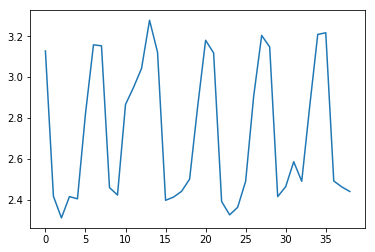

In [26]:
plt.plot(testpreds[129])

In [27]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [28]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.795510   
air_0164b9927d20bcc3_2017-04-23              1.394627   
air_0241aa3964b7f861_2017-04-23              2.354572   
air_0328696196e46f18_2017-04-23              2.030420   
air_034a3d5b40d5b1b1_2017-04-23              3.499995   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.022547  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.033471  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.533623  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   6.617286  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.115280

In [29]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [30]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [31]:
submission.to_csv("../submission/l3_3001_lgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')